# Seasonal Decomposition Analysis
Analyzing merchant transaction patterns using seasonal decomposition to extract trend, seasonality, and residuals.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data
data = pd.read_csv('transactions-by-merchant-id-59935.csv')
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610053 entries, 0 to 610052
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   transaction_id         610053 non-null  int64         
 1   date                   610053 non-null  datetime64[ns]
 2   card_id                610053 non-null  int64         
 3   amount                 610053 non-null  float64       
 4   use_chip               610053 non-null  object        
 5   merchant_id            610053 non-null  int64         
 6   merchant_city          610053 non-null  object        
 7   merchant_state         610053 non-null  object        
 8   zip                    606345 non-null  float64       
 9   mcc                    610053 non-null  int64         
 10  errors                 11417 non-null   object        
 11  is_fraud               610053 non-null  int64         
 12  card_brand             610053 non-null  object   

In [5]:
# Aggregate by month
data['month_period'] = data['date'].dt.to_period('M')
monthly_totals = data.groupby('month_period')['amount'].sum()

# Convert to datetime index for decomposition
monthly_totals.index = monthly_totals.index.to_timestamp()

print(f"Date range: {monthly_totals.index.min()} to {monthly_totals.index.max()}")
print(f"Total months: {len(monthly_totals)}")
monthly_totals.head()

Date range: 2010-01-01 00:00:00 to 2019-10-01 00:00:00
Total months: 118


month_period
2010-01-01    70135.96
2010-02-01    63740.92
2010-03-01    72408.93
2010-04-01    69998.52
2010-05-01    68915.15
Freq: MS, Name: amount, dtype: float64

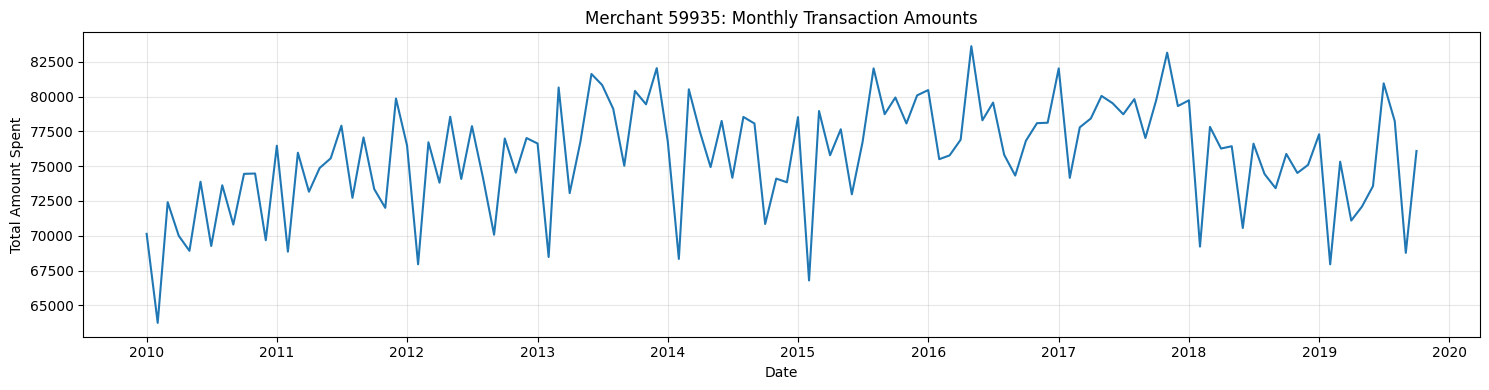

In [ ]:
# Plot the raw time series
plt.figure(figsize=(15, 4))
plt.plot(monthly_totals.index, monthly_totals.values)
plt.xlabel('Date')
plt.ylabel('Total Amount Spent')
plt.title('Merchant 59935: Monthly Transaction Amounts')
plt.grid(True, alpha=0.3)
plt.tight_layout()w
plt.show()

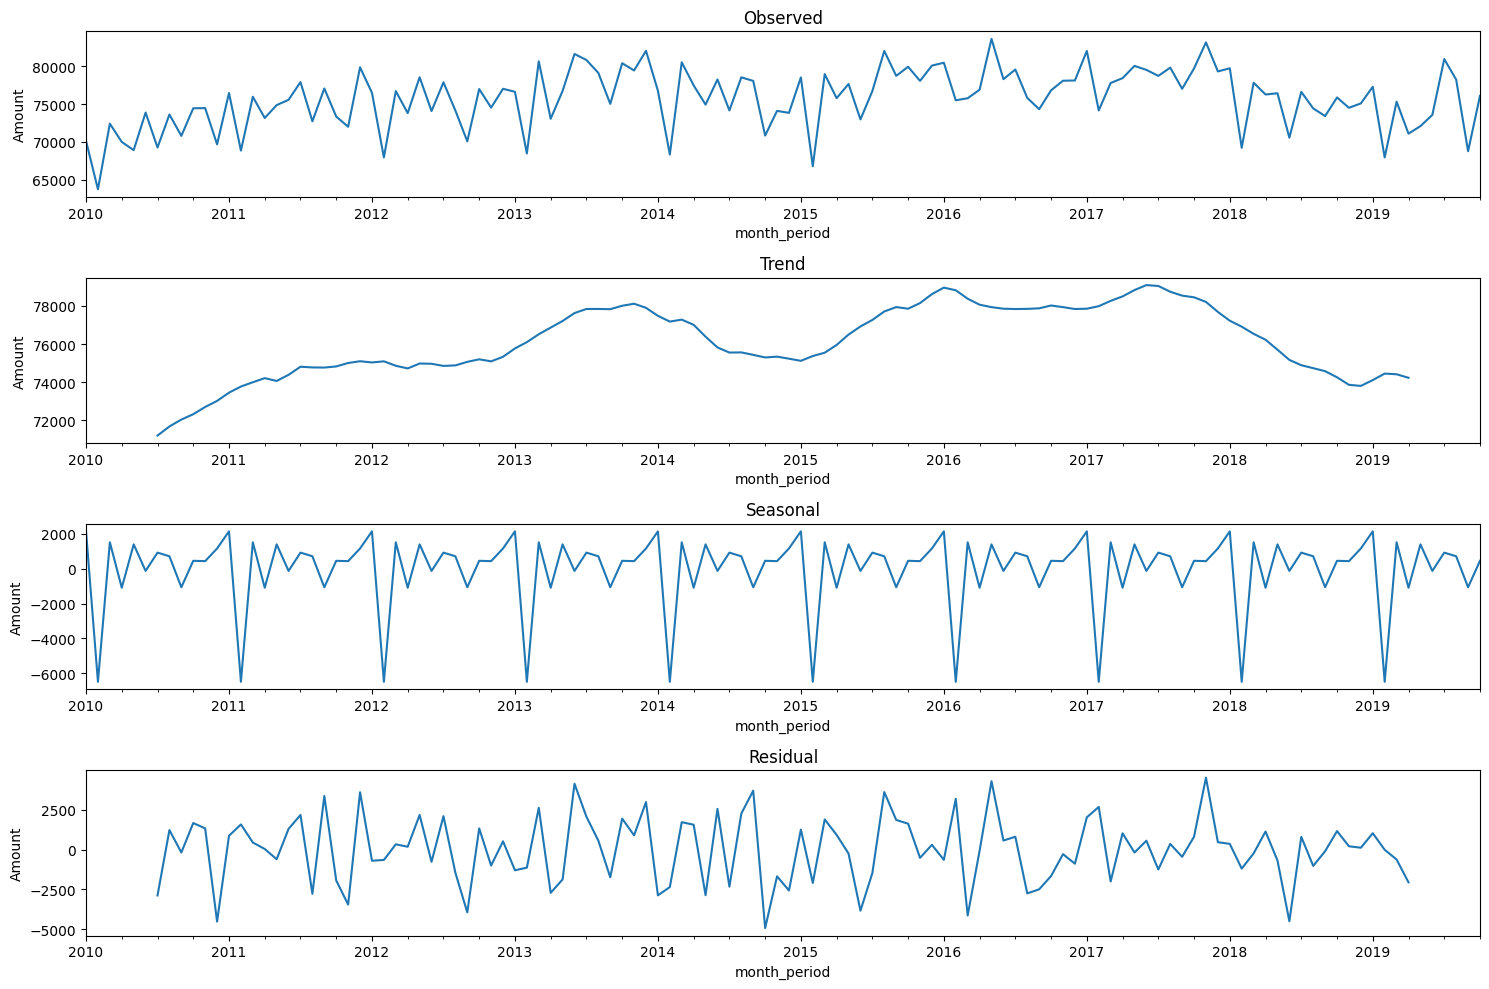

In [4]:
# Perform seasonal decomposition
# period=12 for monthly data (12 months in a year)
decomposition = seasonal_decompose(monthly_totals, model='additive', period=12)

# Plot all components
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

decomposition.observed.plot(ax=axes[0], title='Observed')
axes[0].set_ylabel('Amount')

decomposition.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Amount')

decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
axes[2].set_ylabel('Amount')

decomposition.resid.plot(ax=axes[3], title='Residual')
axes[3].set_ylabel('Amount')

plt.tight_layout()
plt.show()

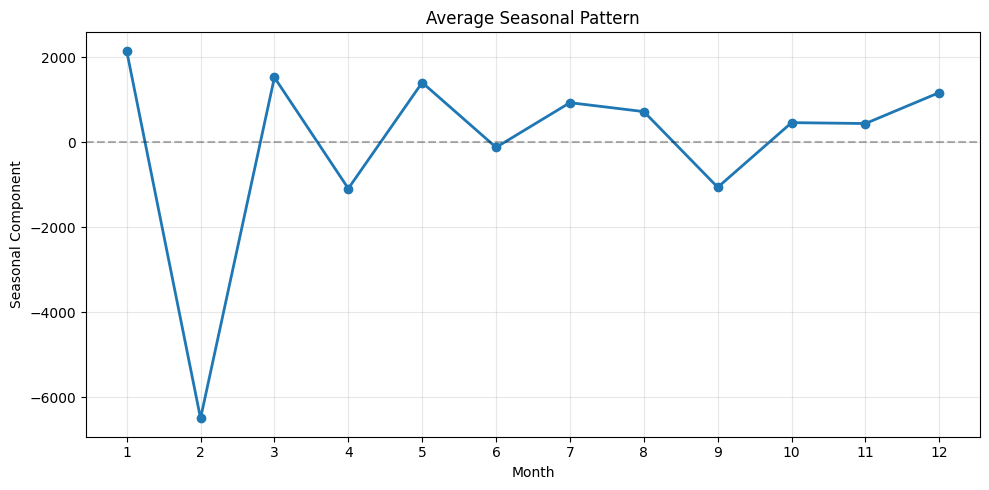

In [5]:
# Extract the seasonal pattern (averaged across all years)
seasonal_pattern = decomposition.seasonal[:12]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), seasonal_pattern.values, marker='o', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Seasonal Component')
plt.title('Average Seasonal Pattern')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Train/Test Split
Split data into training set (historical) and test set (recent year) to validate the pattern.

In [6]:
# Split into train and test (use last year as test)
train = monthly_totals[:-12]
test = monthly_totals[-12:]

print(f"Training data: {train.index.min()} to {train.index.max()} ({len(train)} months)")
print(f"Test data: {test.index.min()} to {test.index.max()} ({len(test)} months)")

Training data: 2010-01-01 00:00:00 to 2018-10-01 00:00:00 (106 months)
Test data: 2018-11-01 00:00:00 to 2019-10-01 00:00:00 (12 months)


In [7]:
# Decompose training data only
decomposition_train = seasonal_decompose(train, model='additive', period=12)

# Get the seasonal pattern from training data
seasonal_pattern_train = decomposition_train.seasonal[:12]

# Get the trend at the end of training period
trend_train = decomposition_train.trend.dropna()
last_trend = trend_train.iloc[-1]

print(f"Last trend value: {last_trend:.2f}")

Last trend value: 76228.07


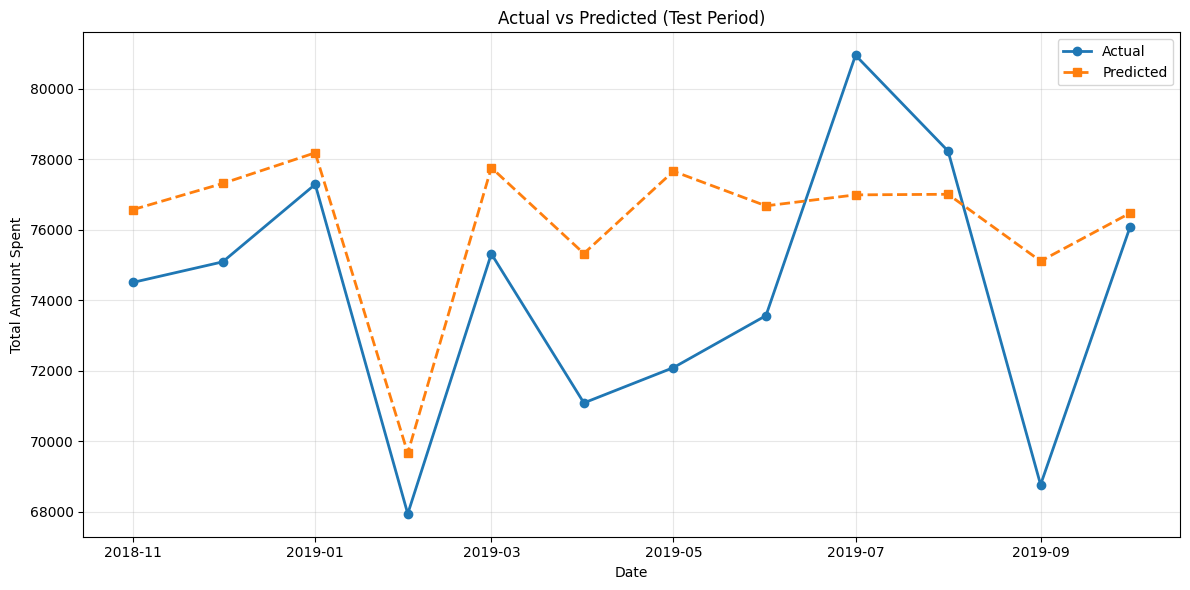


Mean Absolute Error: $2848.01
Mean Absolute Percentage Error: 3.90%


In [8]:
# Predict test period using learned pattern
# Simple approach: last trend value + seasonal pattern
predictions = []
for i, date in enumerate(test.index):
    month = date.month
    seasonal_component = seasonal_pattern_train.iloc[month - 1]
    prediction = last_trend + seasonal_component
    predictions.append(prediction)

predictions = pd.Series(predictions, index=test.index)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, marker='o', label='Actual', linewidth=2)
plt.plot(predictions.index, predictions.values, marker='s', label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Amount Spent')
plt.title('Actual vs Predicted (Test Period)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate error
mae = np.mean(np.abs(test.values - predictions.values))
mape = np.mean(np.abs((test.values - predictions.values) / test.values)) * 100
print(f"\nMean Absolute Error: ${mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

## Anomaly Detection
Identify months where actual spending deviates significantly from expected pattern.

Residual standard deviation: $2083.74
Anomaly threshold: ±$4167.47
Number of anomalies detected: 5


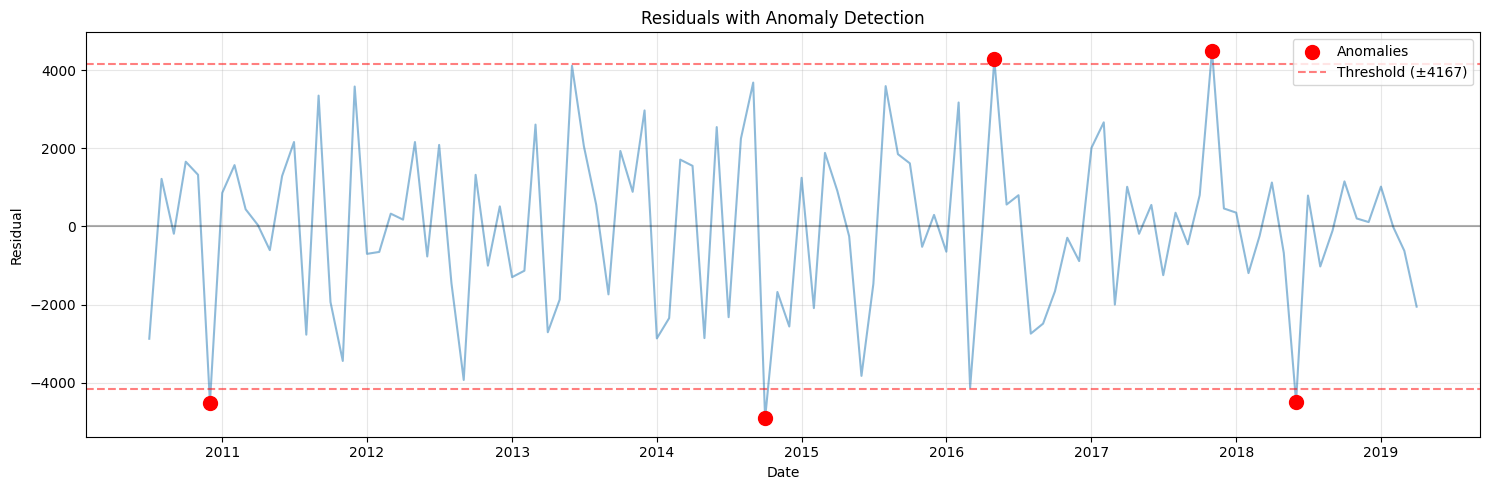


Detected anomalies:
  2010-12: $-4511.73
  2014-10: $-4915.52
  2016-05: $+4280.28
  2017-11: $+4503.50
  2018-06: $-4489.98


In [9]:
# Calculate residuals from the full decomposition
residuals = decomposition.resid.dropna()

# Define anomaly threshold (e.g., 2 standard deviations)
threshold = 2 * residuals.std()

# Find anomalies
anomalies = residuals[np.abs(residuals) > threshold]

print(f"Residual standard deviation: ${residuals.std():.2f}")
print(f"Anomaly threshold: ±${threshold:.2f}")
print(f"Number of anomalies detected: {len(anomalies)}")

# Plot residuals with threshold
plt.figure(figsize=(15, 5))
plt.plot(residuals.index, residuals.values, alpha=0.5)
plt.scatter(anomalies.index, anomalies.values, color='red', s=100, zorder=5, label='Anomalies')
plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.5, label=f'Threshold (±{threshold:.0f})')
plt.axhline(y=-threshold, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals with Anomaly Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(anomalies) > 0:
    print("\nDetected anomalies:")
    for date, value in anomalies.items():
        print(f"  {date.strftime('%Y-%m')}: ${value:+.2f}")

In [10]:
## Error Analysis by Month
# Analyze prediction errors across different months to identify which months are harder to predict.

In [11]:
# For each year, calculate predictions and errors by month
# Use the seasonal pattern from training data to predict all historical data

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Create predictions for all months using the seasonal pattern
errors_by_year_month = []

for year in data['year'].unique():
    year_data = data[data['year'] == year]
    year_monthly = year_data.groupby('month')['amount'].sum()
    
    for month in year_monthly.index:
        actual = year_monthly[month]
        # Use the seasonal pattern + trend
        seasonal_component = seasonal_pattern_train.iloc[month - 1]
        predicted = last_trend + seasonal_component  # Simple model: trend + seasonality
        error = actual - predicted
        percent_error = (error / actual) * 100 if actual != 0 else 0
        
        errors_by_year_month.append({
            'year': year,
            'month': month,
            'actual': actual,
            'predicted': predicted,
            'error': error,
            'abs_error': abs(error),
            'percent_error': percent_error,
            'abs_percent_error': abs(percent_error)
        })

errors_df = pd.DataFrame(errors_by_year_month)
errors_df.head(15)

,year,month,actual,predicted,error,abs_error,percent_error,abs_percent_error
0,2010,1,70135.96,78182.323253,-8046.363253,8046.363253,-11.472522,11.472522
1,2010,2,63740.92,69666.315336,-5925.395336,5925.395336,-9.296062,9.296062
2,2010,3,72408.93,77760.329867,-5351.399867,5351.399867,-7.390525,7.390525
3,2010,4,69998.52,75325.923565,-5327.403565,5327.403565,-7.610737,7.610737
4,2010,5,68915.15,77658.893044,-8743.743044,8743.743044,-12.687694,12.687694
5,2010,6,73879.35,76678.142449,-2798.792449,2798.792449,-3.788328,3.788328
6,2010,7,69261.19,76988.952836,-7727.762836,7727.762836,-11.157421,11.157421
7,2010,8,73623.53,77005.815649,-3382.285649,3382.285649,-4.594028,4.594028
8,2010,9,70799.12,75111.335649,-4312.215649,4312.215649,-6.090776,6.090776
9,2010,10,74444.87,76474.052732,-2029.182732,2029.182732,-2.725752,2.725752


In [12]:
# Calculate average error statistics by month across all years
monthly_error_stats = errors_df.groupby('month').agg({
    'error': ['mean', 'std'],
    'abs_error': ['mean', 'std'],
    'percent_error': ['mean', 'std'],
    'abs_percent_error': ['mean', 'std']
}).round(2)

monthly_error_stats.columns = ['_'.join(col) for col in monthly_error_stats.columns]
print("Average Error Statistics by Month:\n")
print(monthly_error_stats)

Average Error Statistics by Month:

       error_mean  error_std  abs_error_mean  abs_error_std  \
month                                                         
1         -733.38    3211.90         2333.08        2205.87   
2         -569.77    3404.19         2634.51        2058.49   
3         -570.39    2516.52         1954.80        1564.78   
4         -730.41    2805.58         2371.17        1488.93   
5        -1276.54    4092.32         3122.21        2779.64   
6         -849.35    3448.90         3041.98        1553.91   
7          270.67    3477.66         2510.53        2274.31   
8         -159.65    3109.74         2696.70        1272.22   
9         -783.24    3508.28         2868.56        1961.30   
10         -29.54    3060.32         2324.39        1833.97   
11         -88.78    3459.84         2855.27        1675.62   
12         -87.00    3814.40         2940.67        2197.65   

       percent_error_mean  percent_error_std  abs_percent_error_mean  \
month    

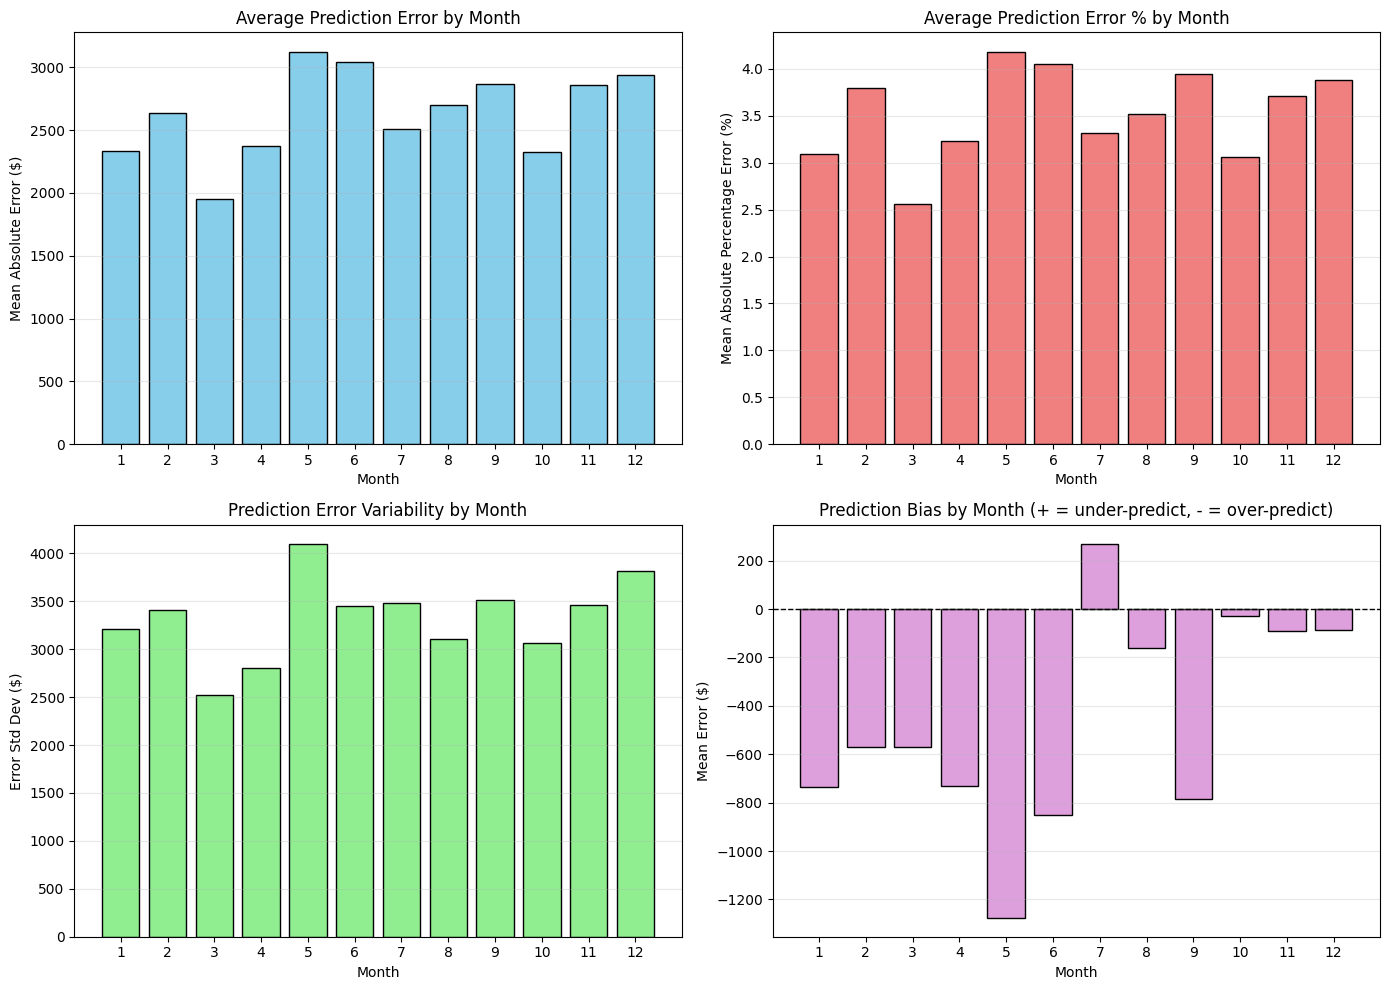

In [13]:
# Visualize average absolute error by month
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean absolute error by month
axes[0, 0].bar(range(1, 13), monthly_error_stats['abs_error_mean'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Mean Absolute Error ($)')
axes[0, 0].set_title('Average Prediction Error by Month')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Mean absolute percentage error by month
axes[0, 1].bar(range(1, 13), monthly_error_stats['abs_percent_error_mean'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Mean Absolute Percentage Error (%)')
axes[0, 1].set_title('Average Prediction Error % by Month')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Error standard deviation by month (variability)
axes[1, 0].bar(range(1, 13), monthly_error_stats['error_std'], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Error Std Dev ($)')
axes[1, 0].set_title('Prediction Error Variability by Month')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Mean error by month (bias - positive means we under-predict, negative means over-predict)
axes[1, 1].bar(range(1, 13), monthly_error_stats['error_mean'], color='plum', edgecolor='black')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Mean Error ($)')
axes[1, 1].set_title('Prediction Bias by Month (+ = under-predict, - = over-predict)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

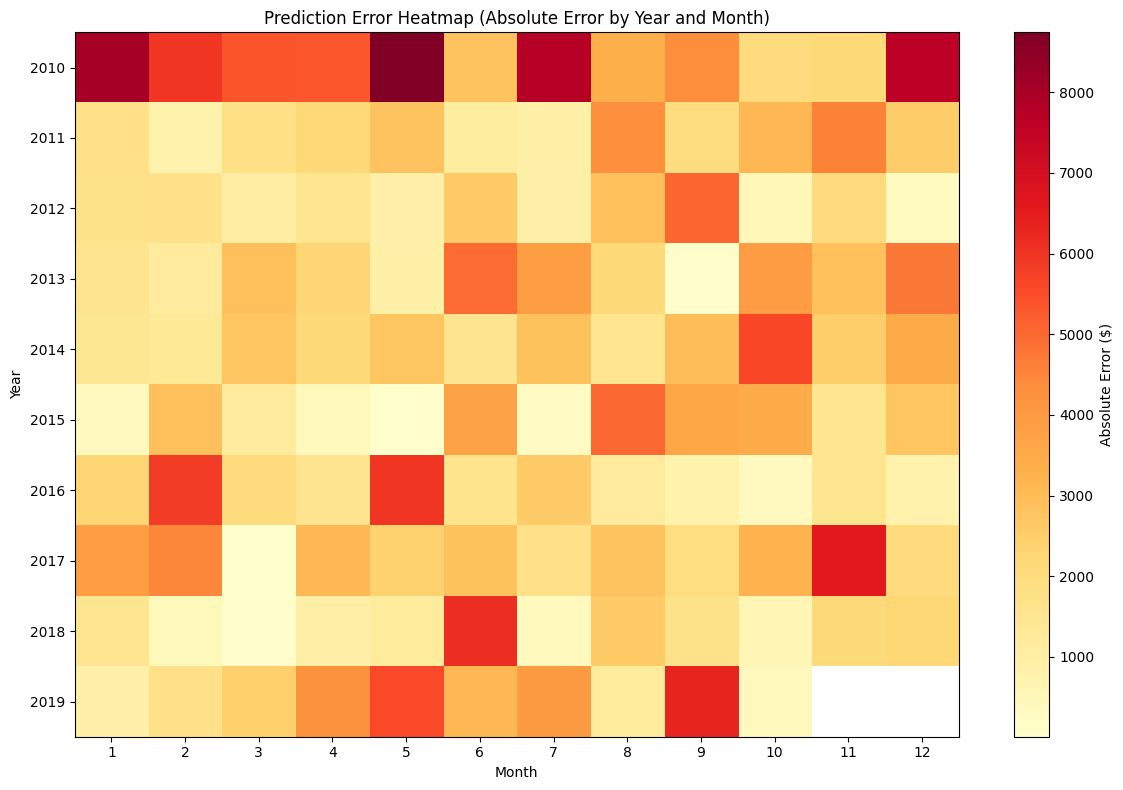


📊 Error Analysis Summary:
   Most predictable month: 3 (Avg error: $1954.80)
   Least predictable month: 5 (Avg error: $3122.21)
   Overall average error: $2637.82


In [14]:
# Heatmap: Error by year and month
pivot_abs_error = errors_df.pivot(index='year', columns='month', values='abs_error')

plt.figure(figsize=(12, 8))
im = plt.imshow(pivot_abs_error.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
plt.colorbar(im, label='Absolute Error ($)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Prediction Error Heatmap (Absolute Error by Year and Month)')
plt.xticks(range(12), range(1, 13))
plt.yticks(range(len(pivot_abs_error.index)), pivot_abs_error.index)
plt.tight_layout()
plt.show()

# Identify the months with highest and lowest average errors
best_month = monthly_error_stats['abs_error_mean'].idxmin()
worst_month = monthly_error_stats['abs_error_mean'].idxmax()

print(f"\n📊 Error Analysis Summary:")
print(f"   Most predictable month: {best_month} (Avg error: ${monthly_error_stats.loc[best_month, 'abs_error_mean']:.2f})")
print(f"   Least predictable month: {worst_month} (Avg error: ${monthly_error_stats.loc[worst_month, 'abs_error_mean']:.2f})")
print(f"   Overall average error: ${monthly_error_stats['abs_error_mean'].mean():.2f}")

C:\Users\matth\AppData\Local\Temp\ipykernel_5780\890801320.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',


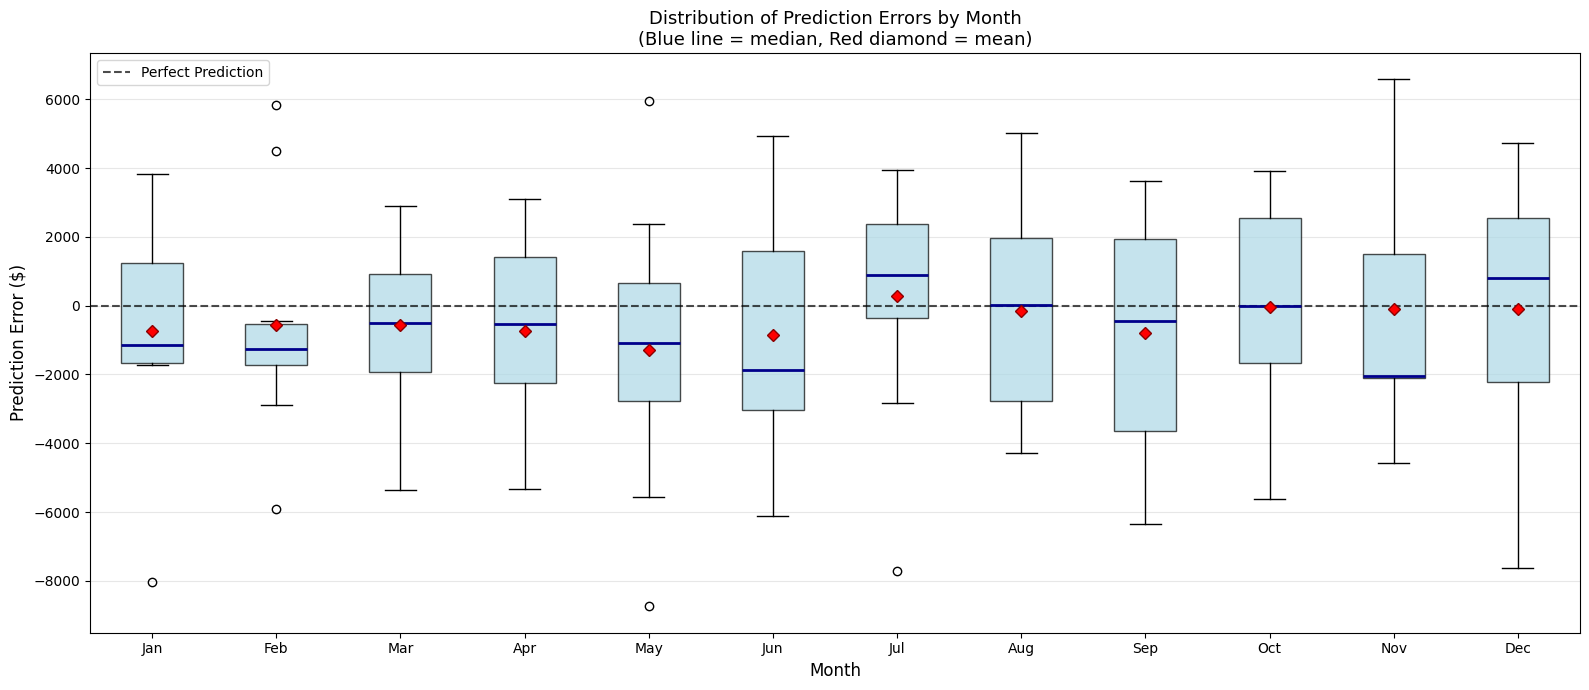


Error Distribution Summary:
Jan: Median=$  -1158, Mean=$   -733, Range=[$-8046 to $+3836]
Feb: Median=$  -1262, Mean=$   -570, Range=[$-5925 to $+5833]
Mar: Median=$   -510, Mean=$   -570, Range=[$-5351 to $+2887]
Apr: Median=$   -531, Mean=$   -730, Range=[$-5327 to $+3097]
May: Median=$  -1074, Mean=$  -1277, Range=[$-8744 to $+5957]
Jun: Median=$  -1859, Mean=$   -849, Range=[$-6120 to $+4941]
Jul: Median=$   +901, Mean=$   +271, Range=[$-7728 to $+3959]
Aug: Median=$    +19, Mean=$   -160, Range=[$-4282 to $+5016]
Sep: Median=$   -437, Mean=$   -783, Range=[$-6341 to $+3618]
Oct: Median=$    -21, Mean=$    -30, Range=[$-5632 to $+3925]
Nov: Median=$  -2041, Mean=$    -89, Range=[$-4570 to $+6578]
Dec: Median=$   +805, Mean=$    -87, Range=[$-7633 to $+4726]


In [15]:
# Box plot: Distribution of errors by month
plt.figure(figsize=(16, 7))

# Create box plot data
box_data = [errors_df[errors_df['month'] == m]['error'].values for m in range(1, 13)]

bp = plt.boxplot(box_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                 patch_artist=True, showmeans=True)

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Color the median lines
for median in bp['medians']:
    median.set_color('darkblue')
    median.set_linewidth(2)

# Color the mean markers
for mean in bp['means']:
    mean.set_marker('D')
    mean.set_markerfacecolor('red')
    mean.set_markeredgecolor('darkred')
    mean.set_markersize(6)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1.5, label='Perfect Prediction')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Prediction Error ($)', fontsize=12)
plt.title('Distribution of Prediction Errors by Month\n(Blue line = median, Red diamond = mean)', fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nError Distribution Summary:")
print("=" * 60)
for i, month_name in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 1):
    month_errors = errors_df[errors_df['month'] == i]['error']
    print(f"{month_name}: Median=${month_errors.median():+7.0f}, Mean=${month_errors.mean():+7.0f}, Range=[${month_errors.min():+.0f} to ${month_errors.max():+.0f}]")

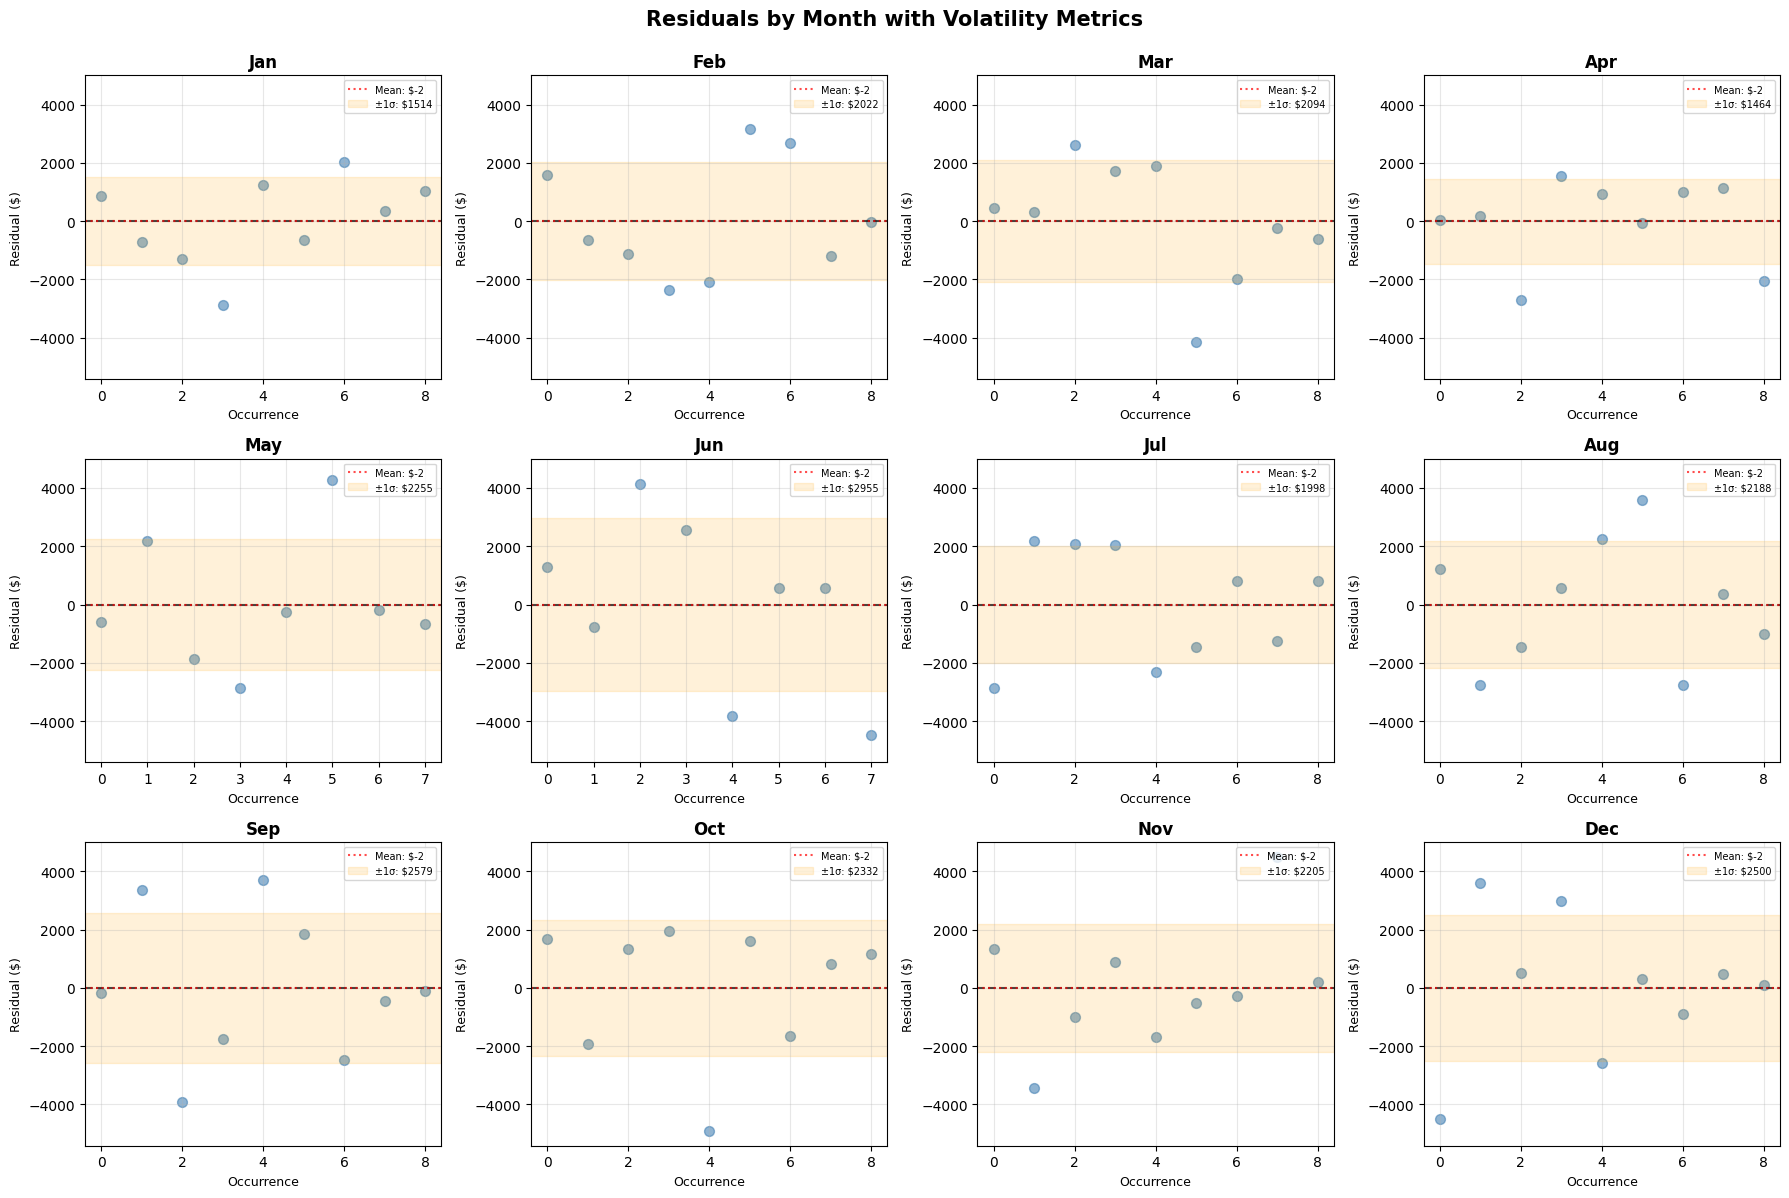


📊 Monthly Residual Volatility Ranking (Highest to Lowest):
Rank  Month   Std Dev     Mean        Median      Count   
1     Jun     $2,955      $-2         $557        8       
2     Sep     $2,579      $-2         $-186       9       
3     Dec     $2,500      $-2         $297        9       
4     Oct     $2,332      $-2         $1,155      9       
5     May     $2,255      $-2         $-429       8       
6     Nov     $2,205      $-2         $-289       9       
7     Aug     $2,188      $-2         $352        9       
8     Mar     $2,094      $-2         $328        9       
9     Feb     $2,022      $-2         $-652       9       
10    Jul     $1,998      $-2         $793        9       
11    Jan     $1,514      $-2         $354        9       
12    Apr     $1,464      $-2         $175        9       

🔍 Key Insights:
   Most volatile month: Jun (σ = $2955)
   Least volatile month: Apr (σ = $1464)
   Volatility ratio: 2.02x


In [17]:
# Plot residuals by month to visualize patterns and volatility
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_stats = []

for month in range(1, 13):
    month_residuals = residuals[residuals.index.month == month]
    
    # Calculate statistics
    std_dev = month_residuals.std()
    mean_res = month_residuals.mean()
    median_res = month_residuals.median()
    
    month_stats.append({
        'month': month,
        'month_name': month_names[month - 1],
        'std_dev': std_dev,
        'mean': mean_res,
        'median': median_res,
        'count': len(month_residuals)
    })
    
    # Plot
    axes[month - 1].scatter(range(len(month_residuals)), month_residuals.values, alpha=0.6, s=50, color='steelblue')
    axes[month - 1].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[month - 1].axhline(y=mean_res, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Mean: ${mean_res:.0f}')
    
    # Add shaded region for ±1 std dev
    axes[month - 1].axhspan(mean_res - std_dev, mean_res + std_dev, alpha=0.15, color='orange', label=f'±1σ: ${std_dev:.0f}')
    
    axes[month - 1].set_title(f'{month_names[month - 1]}', fontsize=12, fontweight='bold')
    axes[month - 1].set_ylabel('Residual ($)', fontsize=9)
    axes[month - 1].set_xlabel('Occurrence', fontsize=9)
    axes[month - 1].grid(True, alpha=0.3)
    axes[month - 1].set_ylim(residuals.min() - 500, residuals.max() + 500)
    axes[month - 1].legend(fontsize=7, loc='upper right')

plt.suptitle('Residuals by Month with Volatility Metrics', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create summary table
stats_df = pd.DataFrame(month_stats)
stats_df = stats_df.sort_values('std_dev', ascending=False)

print("\n📊 Monthly Residual Volatility Ranking (Highest to Lowest):")
print("=" * 70)
print(f"{'Rank':<6}{'Month':<8}{'Std Dev':<12}{'Mean':<12}{'Median':<12}{'Count':<8}")
print("=" * 70)

for idx, row in enumerate(stats_df.itertuples(), 1):
    print(f"{idx:<6}{row.month_name:<8}${row.std_dev:<11,.0f}${row.mean:<11,.0f}${row.median:<11,.0f}{row.count:<8}")

print("\n🔍 Key Insights:")
print(f"   Most volatile month: {stats_df.iloc[0]['month_name']} (σ = ${stats_df.iloc[0]['std_dev']:.0f})")
print(f"   Least volatile month: {stats_df.iloc[-1]['month_name']} (σ = ${stats_df.iloc[-1]['std_dev']:.0f})")
print(f"   Volatility ratio: {stats_df.iloc[0]['std_dev'] / stats_df.iloc[-1]['std_dev']:.2f}x")

# Improved Prediction Methods
Let's compare different approaches to improve prediction accuracy.

## Method 1: Linear Trend Extrapolation
Instead of using a flat trend, fit a linear regression to recent trend data and extrapolate forward.

In [19]:
from sklearn.linear_model import LinearRegression

# Fit linear regression to the trend component
trend_train_clean = decomposition_train.trend.dropna()

# Prepare data for linear regression
X_trend = np.arange(len(trend_train_clean)).reshape(-1, 1)
y_trend = trend_train_clean.values

# Fit the model
lr_model = LinearRegression()
lr_model.fit(X_trend, y_trend)

# Predict trend for test period
test_indices = np.arange(len(trend_train_clean), len(trend_train_clean) + len(test)).reshape(-1, 1)
predicted_trend = lr_model.predict(test_indices)

# Combine with seasonal pattern
predictions_linear = []
for i, date in enumerate(test.index):
    month = date.month
    seasonal_component = seasonal_pattern_train.iloc[month - 1]
    prediction = predicted_trend[i] + seasonal_component
    predictions_linear.append(prediction)

predictions_linear = pd.Series(predictions_linear, index=test.index)

# Calculate error
mae_linear = np.mean(np.abs(test.values - predictions_linear.values))
mape_linear = np.mean(np.abs((test.values - predictions_linear.values) / test.values)) * 100

print(f"Linear Trend Extrapolation Results:")
print(f"  MAE: ${mae_linear:.2f}")
print(f"  MAPE: {mape_linear:.2f}%")
print(f"\nComparison with Flat Trend:")
print(f"  Improvement in MAE: ${mae - mae_linear:.2f} ({((mae - mae_linear)/mae)*100:.1f}%)")
print(f"  Improvement in MAPE: {mape - mape_linear:.2f}%")

Linear Trend Extrapolation Results:
  MAE: $5151.45
  MAPE: 7.08%

Comparison with Flat Trend:
  Improvement in MAE: $-2303.45 (-80.9%)
  Improvement in MAPE: -3.18%


## Method 2: SARIMA Model
SARIMA (Seasonal AutoRegressive Integrated Moving Average) is specifically designed for seasonal time series data.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Fit SARIMA model
# Parameters: (p,d,q) x (P,D,Q,s)
# p,d,q: non-seasonal AR, differencing, MA
# P,D,Q: seasonal AR, differencing, MA
# s: seasonal period (12 for monthly data)

print("Fitting SARIMA model (this may take a minute)...")

# Start with a simple model: SARIMA(1,1,1)(1,1,1,12)
sarima_model = SARIMAX(train, 
                       order=(1, 1, 1),           # (p, d, q)
                       seasonal_order=(1, 1, 1, 12),  # (P, D, Q, s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Make predictions
predictions_sarima = sarima_result.forecast(steps=len(test))
predictions_sarima = pd.Series(predictions_sarima.values, index=test.index)

# Calculate error
mae_sarima = np.mean(np.abs(test.values - predictions_sarima.values))
mape_sarima = np.mean(np.abs((test.values - predictions_sarima.values) / test.values)) * 100

print(f"\nSARIMA Model Results:")
print(f"  MAE: ${mae_sarima:.2f}")
print(f"  MAPE: {mape_sarima:.2f}%")
print(f"\nComparison with Flat Trend:")
print(f"  Improvement in MAE: ${mae - mae_sarima:.2f} ({((mae - mae_sarima)/mae)*100:.1f}%)")
print(f"  Improvement in MAPE: {mape - mape_sarima:.2f}%")

Fitting SARIMA model (this may take a minute)...

SARIMA Model Results:
  MAE: $2524.59
  MAPE: 3.35%

Comparison with Flat Trend:
  Improvement in MAE: $323.42 (11.4%)
  Improvement in MAPE: 0.55%


## Method 3: Exponential Smoothing (Holt-Winters)
Uses weighted averages with exponential decay, giving more weight to recent observations.

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model
hw_model = ExponentialSmoothing(train, 
                                seasonal_periods=12,
                                trend='add',
                                seasonal='add')

hw_result = hw_model.fit()

# Make predictions
predictions_hw = hw_result.forecast(steps=len(test))
predictions_hw = pd.Series(predictions_hw.values, index=test.index)

# Calculate error
mae_hw = np.mean(np.abs(test.values - predictions_hw.values))
mape_hw = np.mean(np.abs((test.values - predictions_hw.values) / test.values)) * 100

print(f"Holt-Winters Model Results:")
print(f"  MAE: ${mae_hw:.2f}")
print(f"  MAPE: {mape_hw:.2f}%")
print(f"\nComparison with Flat Trend:")
print(f"  Improvement in MAE: ${mae - mae_hw:.2f} ({((mae - mae_hw)/mae)*100:.1f}%)")
print(f"  Improvement in MAPE: {mape - mape_hw:.2f}%")

Holt-Winters Model Results:
  MAE: $2295.76
  MAPE: 3.13%

Comparison with Flat Trend:
  Improvement in MAE: $552.25 (19.4%)
  Improvement in MAPE: 0.77%


## Comparison: All Methods

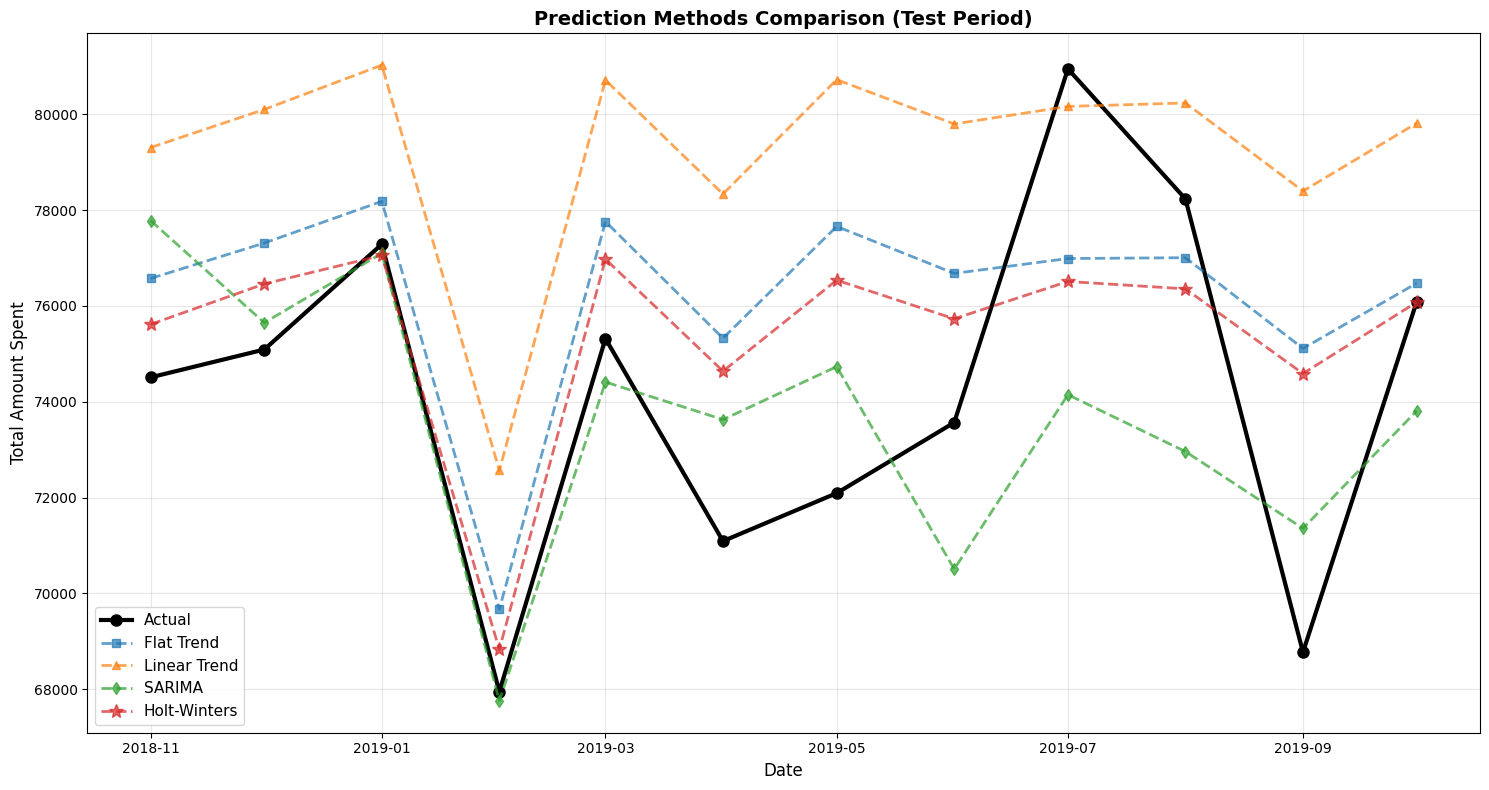


MODEL PERFORMANCE COMPARISON (Sorted by MAE)
 Rank       Method         MAE  MAPE (%)
    1 Holt-Winters 2295.756207  3.130279
    2       SARIMA 2524.585545  3.346260
    3   Flat Trend 2848.008586  3.897178
    4 Linear Trend 5151.453779  7.081788

🏆 Best Model: Holt-Winters
   MAE: $2295.76
   MAPE: 3.13%


In [22]:
# Compare all methods visually
plt.figure(figsize=(15, 8))

plt.plot(test.index, test.values, marker='o', label='Actual', linewidth=3, color='black', markersize=8)
plt.plot(predictions.index, predictions.values, marker='s', label='Flat Trend', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(predictions_linear.index, predictions_linear.values, marker='^', label='Linear Trend', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(predictions_sarima.index, predictions_sarima.values, marker='d', label='SARIMA', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(predictions_hw.index, predictions_hw.values, marker='*', label='Holt-Winters', linewidth=2, linestyle='--', alpha=0.7, markersize=10)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Amount Spent', fontsize=12)
plt.title('Prediction Methods Comparison (Test Period)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
comparison_df = pd.DataFrame({
    'Method': ['Flat Trend', 'Linear Trend', 'SARIMA', 'Holt-Winters'],
    'MAE': [mae, mae_linear, mae_sarima, mae_hw],
    'MAPE (%)': [mape, mape_linear, mape_sarima, mape_hw]
})

comparison_df = comparison_df.sort_values('MAE')
comparison_df['Rank'] = range(1, len(comparison_df) + 1)
comparison_df = comparison_df[['Rank', 'Method', 'MAE', 'MAPE (%)']]

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON (Sorted by MAE)")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

best_model = comparison_df.iloc[0]['Method']
best_mae = comparison_df.iloc[0]['MAE']
best_mape = comparison_df.iloc[0]['MAPE (%)']

print(f"\n🏆 Best Model: {best_model}")
print(f"   MAE: ${best_mae:.2f}")
print(f"   MAPE: {best_mape:.2f}%")

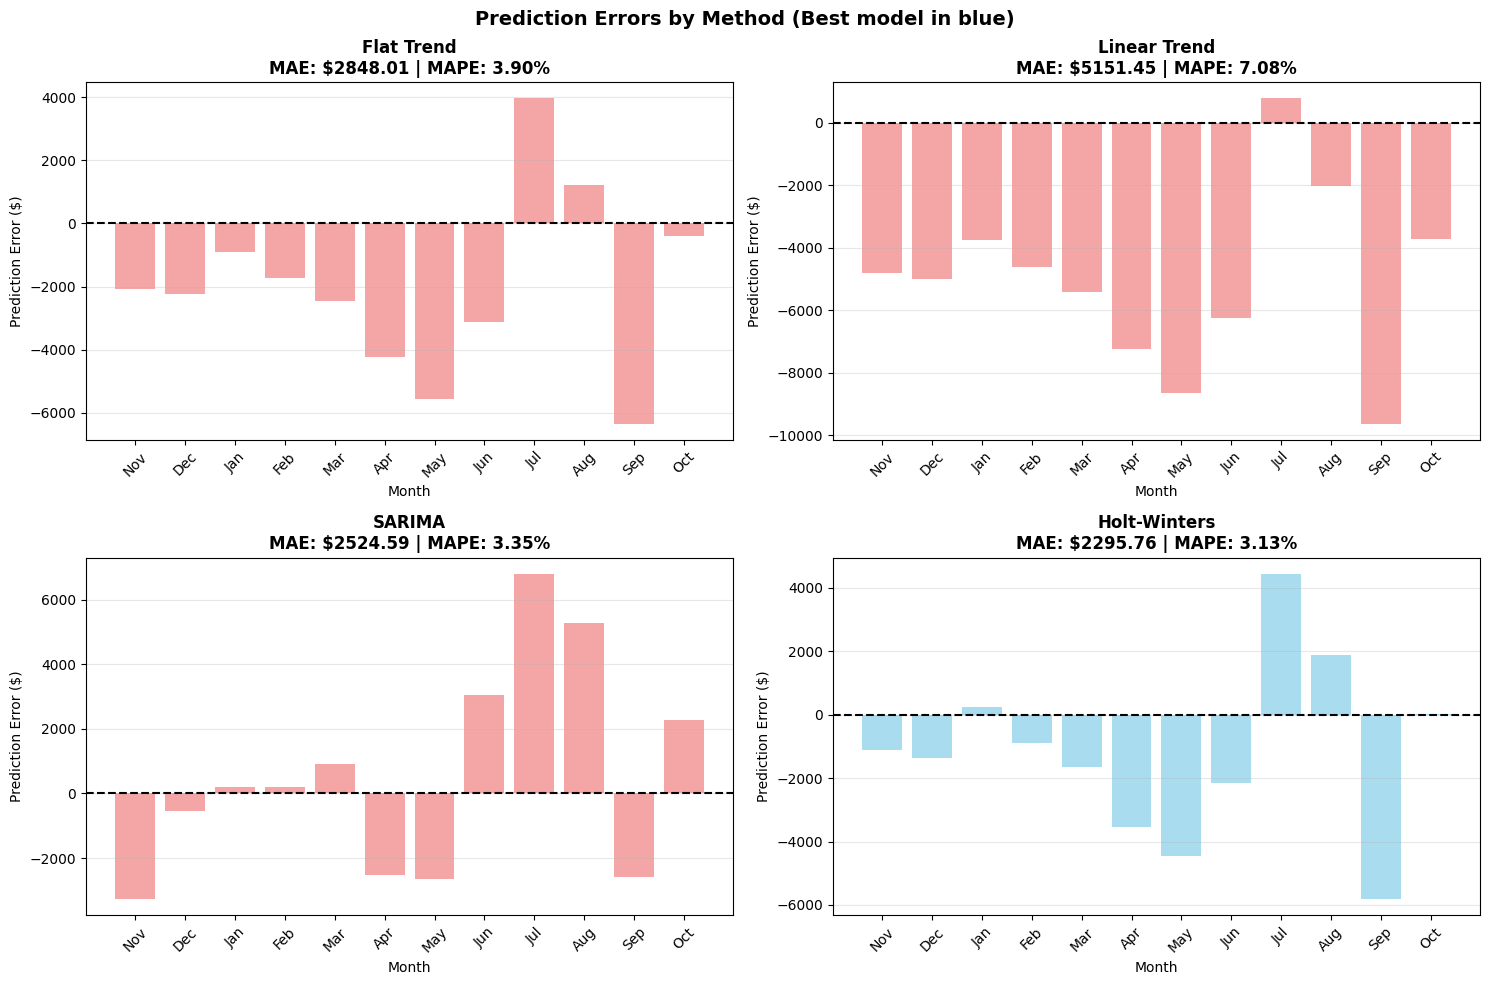

In [23]:
# Visualize prediction errors for each method
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

methods = [
    ('Flat Trend', predictions, mae, mape),
    ('Linear Trend', predictions_linear, mae_linear, mape_linear),
    ('SARIMA', predictions_sarima, mae_sarima, mape_sarima),
    ('Holt-Winters', predictions_hw, mae_hw, mape_hw)
]

for idx, (name, preds, m, mp) in enumerate(methods):
    row = idx // 2
    col = idx % 2
    
    errors = test.values - preds.values
    
    axes[row, col].bar(range(len(errors)), errors, alpha=0.7, 
                       color='skyblue' if m == min([mae, mae_linear, mae_sarima, mae_hw]) else 'lightcoral')
    axes[row, col].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    axes[row, col].set_title(f'{name}\nMAE: ${m:.2f} | MAPE: {mp:.2f}%', fontweight='bold')
    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel('Prediction Error ($)')
    axes[row, col].set_xticks(range(len(test)))
    axes[row, col].set_xticklabels([d.strftime('%b') for d in test.index], rotation=45)
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.suptitle('Prediction Errors by Method (Best model in blue)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Machine Learning Approaches
Now let's explore ML-based methods with engineered features.

## Feature Engineering
Create time-based features and lagged values for ML models.

In [24]:
# Create a dataframe with engineered features
df_ml = pd.DataFrame({
    'amount': monthly_totals.values,
    'date': monthly_totals.index
})

# Time-based features
df_ml['month'] = df_ml['date'].dt.month
df_ml['year'] = df_ml['date'].dt.year
df_ml['quarter'] = df_ml['date'].dt.quarter
df_ml['year_progress'] = (df_ml['date'].dt.dayofyear / 365.25)

# Cyclical encoding for month (captures that Dec and Jan are close)
df_ml['month_sin'] = np.sin(2 * np.pi * df_ml['month'] / 12)
df_ml['month_cos'] = np.cos(2 * np.pi * df_ml['month'] / 12)

# Lagged features (previous months)
for lag in [1, 2, 3, 6, 12]:
    df_ml[f'lag_{lag}'] = df_ml['amount'].shift(lag)

# Rolling statistics
for window in [3, 6, 12]:
    df_ml[f'rolling_mean_{window}'] = df_ml['amount'].shift(1).rolling(window=window).mean()
    df_ml[f'rolling_std_{window}'] = df_ml['amount'].shift(1).rolling(window=window).std()

# Year-over-year change
df_ml['yoy_change'] = df_ml['amount'] - df_ml['amount'].shift(12)

# Drop rows with NaN (from lagging and rolling)
df_ml_clean = df_ml.dropna()

print(f"Original data: {len(df_ml)} rows")
print(f"After feature engineering: {len(df_ml_clean)} rows")
print(f"\nFeatures created: {df_ml_clean.columns.tolist()}")
print(f"\nSample data:")
df_ml_clean.head()

Original data: 118 rows
After feature engineering: 106 rows

Features created: ['amount', 'date', 'month', 'year', 'quarter', 'year_progress', 'month_sin', 'month_cos', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_6', 'rolling_std_6', 'rolling_mean_12', 'rolling_std_12', 'yoy_change']

Sample data:


,amount,date,month,year,quarter,year_progress,month_sin,month_cos,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_std_3,rolling_mean_6,rolling_std_6,rolling_mean_12,rolling_std_12,yoy_change
12,76465.49,2011-01-01,1,2011,1,0.002738,0.500000,8.660254e-01,69679.42,74468.93,74444.87,69261.19,70135.96,72864.406667,2758.305598,72046.176667,2409.329581,70946.324167,3084.017379,6329.53
13,68854.53,2011-02-01,2,2011,1,0.087611,0.866025,5.000000e-01,76465.49,69679.42,74468.93,73623.53,63740.92,73537.946667,3487.511145,73246.893333,2535.673546,71473.785000,3452.123423,5113.61
14,75964.35,2011-03-01,3,2011,1,0.164271,1.000000,6.123234e-17,68854.53,76465.49,69679.42,70799.12,72408.93,71666.480000,4176.479811,72452.060000,3082.487371,71899.919167,2628.046788,3555.42
15,73161.09,2011-04-01,4,2011,2,0.249144,0.866025,-5.000000e-01,75964.35,68854.53,76465.49,74444.87,69998.52,73761.456667,4256.904076,73312.931667,3245.489554,72196.204167,2879.078411,3162.57
16,74863.66,2011-05-01,5,2011,2,0.331280,0.500000,-8.660254e-01,73161.09,75964.35,68854.53,74468.93,68915.15,72659.990000,3581.300185,73098.968333,3197.908750,72459.751667,2803.370034,5948.51


In [25]:
# Prepare train/test split for ML models
# Use the same 12-month test period as before
train_size = len(df_ml_clean) - 12
X_train_ml = df_ml_clean.iloc[:train_size].drop(['amount', 'date'], axis=1)
y_train_ml = df_ml_clean.iloc[:train_size]['amount']
X_test_ml = df_ml_clean.iloc[train_size:].drop(['amount', 'date'], axis=1)
y_test_ml = df_ml_clean.iloc[train_size:]['amount']
test_dates_ml = df_ml_clean.iloc[train_size:]['date']

print(f"Training samples: {len(X_train_ml)}")
print(f"Test samples: {len(X_test_ml)}")
print(f"\nFeatures: {X_train_ml.columns.tolist()}")

Training samples: 94
Test samples: 12

Features: ['month', 'year', 'quarter', 'year_progress', 'month_sin', 'month_cos', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_6', 'rolling_std_6', 'rolling_mean_12', 'rolling_std_12', 'yoy_change']


## Method 4: Random Forest Regression
Ensemble of decision trees that can capture non-linear patterns.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Scale features
scaler_rf = StandardScaler()
X_train_scaled = scaler_rf.fit_transform(X_train_ml)
X_test_scaled = scaler_rf.transform(X_test_ml)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train_ml)

# Predictions
predictions_rf = rf_model.predict(X_test_scaled)
predictions_rf = pd.Series(predictions_rf, index=test_dates_ml)

# Calculate errors
mae_rf = np.mean(np.abs(y_test_ml.values - predictions_rf.values))
mape_rf = np.mean(np.abs((y_test_ml.values - predictions_rf.values) / y_test_ml.values)) * 100

print(f"\nRandom Forest Results:")
print(f"  MAE: ${mae_rf:.2f}")
print(f"  MAPE: {mape_rf:.2f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_ml.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

Training Random Forest...

Random Forest Results:
  MAE: $2013.45
  MAPE: 2.78%

Top 5 Most Important Features:
       feature  importance
        lag_12    0.408934
    yoy_change    0.340935
rolling_mean_6    0.031583
          year    0.031337
         lag_2    0.027341


## Method 5: XGBoost
Gradient boosting method that builds trees sequentially to correct previous errors.

In [27]:
try:
    import xgboost as xgb
    
    # Train XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    print("Training XGBoost...")
    xgb_model.fit(X_train_scaled, y_train_ml)
    
    # Predictions
    predictions_xgb = xgb_model.predict(X_test_scaled)
    predictions_xgb = pd.Series(predictions_xgb, index=test_dates_ml)
    
    # Calculate errors
    mae_xgb = np.mean(np.abs(y_test_ml.values - predictions_xgb.values))
    mape_xgb = np.mean(np.abs((y_test_ml.values - predictions_xgb.values) / y_test_ml.values)) * 100
    
    print(f"\nXGBoost Results:")
    print(f"  MAE: ${mae_xgb:.2f}")
    print(f"  MAPE: {mape_xgb:.2f}%")
    
    xgb_available = True
    
except ImportError:
    print("XGBoost not installed. Run: uv add xgboost")
    print("Skipping XGBoost model...")
    xgb_available = False
    predictions_xgb = None
    mae_xgb = float('inf')
    mape_xgb = float('inf')

Training XGBoost...

XGBoost Results:
  MAE: $1978.68
  MAPE: 2.72%


## Method 6: LSTM Neural Network
Long Short-Term Memory network designed for sequential data and time series.

In [28]:
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    
    # Prepare sequences for LSTM (lookback window of 12 months)
    lookback = 12
    
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i])
            y.append(data[i])
        return np.array(X), np.array(y)
    
    # Normalize data
    from sklearn.preprocessing import MinMaxScaler
    scaler_lstm = MinMaxScaler()
    scaled_data = scaler_lstm.fit_transform(monthly_totals.values.reshape(-1, 1))
    
    # Create sequences
    X_lstm, y_lstm = create_sequences(scaled_data, lookback)
    
    # Split
    train_size_lstm = len(X_lstm) - 12
    X_train_lstm = X_lstm[:train_size_lstm]
    y_train_lstm = y_lstm[:train_size_lstm]
    X_test_lstm = X_lstm[train_size_lstm:]
    y_test_lstm = y_lstm[train_size_lstm:]
    
    # Reshape for LSTM [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
    
    # Build LSTM model
    model_lstm = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    print("Training LSTM (this may take a minute)...")
    history = model_lstm.fit(
        X_train_lstm, y_train_lstm,
        epochs=100,
        batch_size=16,
        verbose=0,
        callbacks=[early_stop]
    )
    
    # Predictions
    predictions_lstm_scaled = model_lstm.predict(X_test_lstm, verbose=0)
    predictions_lstm = scaler_lstm.inverse_transform(predictions_lstm_scaled)
    
    # Get corresponding dates
    test_dates_lstm = monthly_totals.index[train_size_lstm + lookback:]
    predictions_lstm = pd.Series(predictions_lstm.flatten(), index=test_dates_lstm)
    
    # Calculate errors
    y_test_lstm_original = scaler_lstm.inverse_transform(y_test_lstm).flatten()
    mae_lstm = np.mean(np.abs(y_test_lstm_original - predictions_lstm.values))
    mape_lstm = np.mean(np.abs((y_test_lstm_original - predictions_lstm.values) / y_test_lstm_original)) * 100
    
    print(f"\nLSTM Results:")
    print(f"  MAE: ${mae_lstm:.2f}")
    print(f"  MAPE: {mape_lstm:.2f}%")
    print(f"  Training epochs: {len(history.history['loss'])}")
    
    lstm_available = True
    
except ImportError as e:
    print(f"TensorFlow/Keras not installed: {e}")
    print("Run: uv add tensorflow")
    print("Skipping LSTM model...")
    lstm_available = False
    predictions_lstm = None
    mae_lstm = float('inf')
    mape_lstm = float('inf')

Training LSTM (this may take a minute)...

LSTM Results:
  MAE: $3183.97
  MAPE: 4.39%
  Training epochs: 19


## Method 7: Ensemble (Weighted Average)
Combine multiple models for potentially better and more robust predictions.

In [30]:
# Combine top performing models using inverse MAE as weights
# Models to ensemble: SARIMA, Holt-Winters, Random Forest

ensemble_models = {
    'SARIMA': (predictions_sarima, mae_sarima),
    'Holt-Winters': (predictions_hw, mae_hw),
    'Random Forest': (predictions_rf, mae_rf)
}

# Calculate weights (inverse of error, normalized)
total_inverse_error = sum(1/mae for _, mae in ensemble_models.values())
weights = {name: (1/mae) / total_inverse_error for name, (_, mae) in ensemble_models.items()}

print("Ensemble Weights:")
for name, weight in weights.items():
    print(f"  {name}: {weight:.3f}")

# Create ensemble prediction (only for overlapping indices)
common_index = predictions_sarima.index.intersection(predictions_hw.index).intersection(predictions_rf.index)

predictions_ensemble = pd.Series(0, index=common_index)
for name, (pred, _) in ensemble_models.items():
    predictions_ensemble += weights[name] * pred[common_index]

# Calculate errors
y_test_ensemble = test.loc[common_index]
mae_ensemble = np.mean(np.abs(y_test_ensemble.values - predictions_ensemble.values))
mape_ensemble = np.mean(np.abs((y_test_ensemble.values - predictions_ensemble.values) / y_test_ensemble.values)) * 100

print(f"\nEnsemble Results:")
print(f"  MAE: ${mae_ensemble:.2f}")
print(f"  MAPE: {mape_ensemble:.2f}%")

Ensemble Weights:
  SARIMA: 0.298
  Holt-Winters: 0.328
  Random Forest: 0.374

Ensemble Results:
  MAE: $1855.40
  MAPE: 2.52%


## Comprehensive Comparison: All Methods

In [31]:
# Comprehensive comparison table
all_methods = {
    'Flat Trend': (mae, mape, 'Statistical'),
    'Linear Trend': (mae_linear, mape_linear, 'Statistical'),
    'SARIMA': (mae_sarima, mape_sarima, 'Statistical'),
    'Holt-Winters': (mae_hw, mape_hw, 'Statistical'),
    'Random Forest': (mae_rf, mape_rf, 'Machine Learning'),
    'Ensemble': (mae_ensemble, mape_ensemble, 'Hybrid')
}

# Add optional models if available
if xgb_available:
    all_methods['XGBoost'] = (mae_xgb, mape_xgb, 'Machine Learning')
if lstm_available:
    all_methods['LSTM'] = (mae_lstm, mape_lstm, 'Deep Learning')

# Create comparison dataframe
comparison_all = pd.DataFrame([
    {'Method': name, 'MAE': mae_val, 'MAPE (%)': mape_val, 'Category': cat}
    for name, (mae_val, mape_val, cat) in all_methods.items()
    if mae_val != float('inf')
])

comparison_all = comparison_all.sort_values('MAE')
comparison_all['Rank'] = range(1, len(comparison_all) + 1)
comparison_all['Improvement vs Baseline'] = ((comparison_all['MAE'].max() - comparison_all['MAE']) / comparison_all['MAE'].max() * 100).round(1)
comparison_all = comparison_all[['Rank', 'Method', 'Category', 'MAE', 'MAPE (%)', 'Improvement vs Baseline']]

print("\n" + "="*90)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*90)
print(comparison_all.to_string(index=False))
print("="*90)

# Highlight top 3
print(f"\n🥇 Best: {comparison_all.iloc[0]['Method']} - MAE: ${comparison_all.iloc[0]['MAE']:.2f}")
print(f"🥈 Second: {comparison_all.iloc[1]['Method']} - MAE: ${comparison_all.iloc[1]['MAE']:.2f}")
print(f"🥉 Third: {comparison_all.iloc[2]['Method']} - MAE: ${comparison_all.iloc[2]['MAE']:.2f}")

# Category-wise best
print(f"\nBest by Category:")
for category in comparison_all['Category'].unique():
    cat_best = comparison_all[comparison_all['Category'] == category].iloc[0]
    print(f"  {category}: {cat_best['Method']} (MAE: ${cat_best['MAE']:.2f})")


COMPREHENSIVE MODEL PERFORMANCE COMPARISON
 Rank        Method         Category         MAE  MAPE (%)  Improvement vs Baseline
    1      Ensemble           Hybrid 1855.402843  2.521778                     64.0
    2       XGBoost Machine Learning 1978.681563  2.720164                     61.6
    3 Random Forest Machine Learning 2013.447758  2.780099                     60.9
    4  Holt-Winters      Statistical 2295.756207  3.130279                     55.4
    5        SARIMA      Statistical 2524.585545  3.346260                     51.0
    6    Flat Trend      Statistical 2848.008586  3.897178                     44.7
    7          LSTM    Deep Learning 3183.974766  4.385065                     38.2
    8  Linear Trend      Statistical 5151.453779  7.081788                      0.0

🥇 Best: Ensemble - MAE: $1855.40
🥈 Second: XGBoost - MAE: $1978.68
🥉 Third: Random Forest - MAE: $2013.45

Best by Category:
  Hybrid: Ensemble (MAE: $1855.40)
  Machine Learning: XGBoost (MAE: $1978

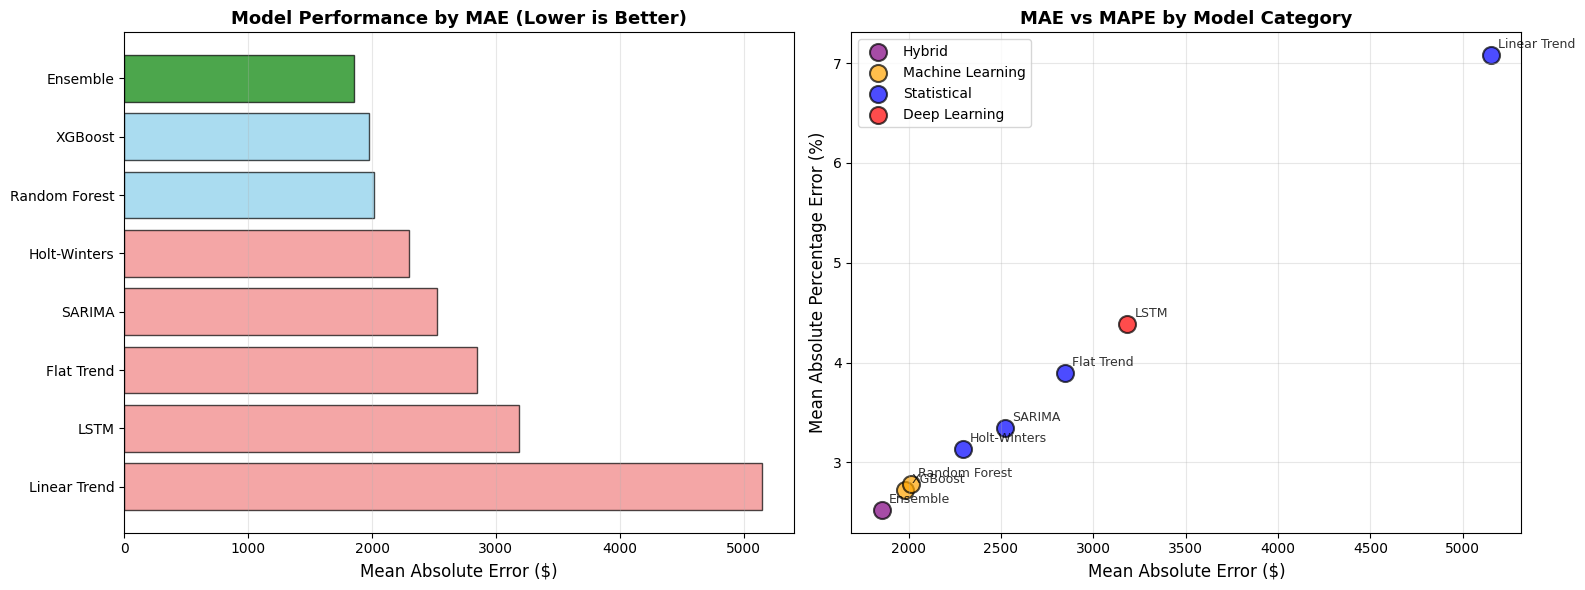

In [32]:
# Visualize all methods performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of MAE
methods_list = comparison_all['Method'].tolist()
mae_list = comparison_all['MAE'].tolist()
colors = ['green' if i == 0 else 'skyblue' if i < 3 else 'lightcoral' 
          for i in range(len(mae_list))]

axes[0].barh(methods_list, mae_list, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Mean Absolute Error ($)', fontsize=12)
axes[0].set_title('Model Performance by MAE (Lower is Better)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Scatter: MAE vs MAPE
categories_colors = {'Statistical': 'blue', 'Machine Learning': 'orange', 'Deep Learning': 'red', 'Hybrid': 'purple'}
for category in comparison_all['Category'].unique():
    cat_data = comparison_all[comparison_all['Category'] == category]
    axes[1].scatter(cat_data['MAE'], cat_data['MAPE (%)'], 
                   label=category, s=150, alpha=0.7, 
                   color=categories_colors.get(category, 'gray'),
                   edgecolors='black', linewidth=1.5)
    
    # Annotate points
    for _, row in cat_data.iterrows():
        axes[1].annotate(row['Method'], 
                        (row['MAE'], row['MAPE (%)']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, alpha=0.8)

axes[1].set_xlabel('Mean Absolute Error ($)', fontsize=12)
axes[1].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[1].set_title('MAE vs MAPE by Model Category', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Time-Series Cross-Validation

Now let's evaluate how the models perform with progressively less training data to understand data requirements and model stability.

In [1]:
# Define cross-validation splits
# We'll train on progressively less data to predict each year from 2013 onwards
# This helps us understand:
# 1. How much historical data is needed for good performance
# 2. Whether model performance is stable across different time periods

cv_results = []

# Define the years to predict (test years)
test_years = range(2013, 2020)  # 2013 to 2019

print("="*80)
print("TIME-SERIES CROSS-VALIDATION SETUP")
print("="*80)

for test_year in test_years:
    # Training data: all data from 2010 up to (but not including) the test year
    # Test data: the entire test year (12 months)
    train_end_year = test_year - 1
    
    # Calculate training window size in years
    training_years = train_end_year - 2010 + 1
    
    print(f"\nFold: Train on 2010-{train_end_year} → Predict {test_year}")
    print(f"  Training window: {training_years} years")
    
    cv_results.append({
        'test_year': test_year,
        'train_start': 2010,
        'train_end': train_end_year,
        'training_years': training_years
    })

print(f"\nTotal CV folds: {len(cv_results)}")
print("="*80)

TIME-SERIES CROSS-VALIDATION SETUP

Fold: Train on 2010-2012 → Predict 2013
  Training window: 3 years

Fold: Train on 2010-2013 → Predict 2014
  Training window: 4 years

Fold: Train on 2010-2014 → Predict 2015
  Training window: 5 years

Fold: Train on 2010-2015 → Predict 2016
  Training window: 6 years

Fold: Train on 2010-2016 → Predict 2017
  Training window: 7 years

Fold: Train on 2010-2017 → Predict 2018
  Training window: 8 years

Fold: Train on 2010-2018 → Predict 2019
  Training window: 9 years

Total CV folds: 7


In [13]:
# Import necessary libraries for cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb

print("Cross-validation libraries imported successfully!")

Cross-validation libraries imported successfully!


In [14]:
# Function to perform cross-validation for all models
def perform_cv_fold(monthly_data, test_year, train_start=2010):
    """
    Perform one fold of cross-validation
    
    Parameters:
    - monthly_data: Monthly aggregated transaction data
    - test_year: Year to predict
    - train_start: Start year for training (default 2010)
    
    Returns:
    - Dictionary with MAE and MAPE for each model
    """
    train_end = test_year - 1
    
    # Split data
    train_data = monthly_data[(monthly_data.index.year >= train_start) & 
                              (monthly_data.index.year <= train_end)]
    test_data = monthly_data[monthly_data.index.year == test_year]
    
    # Ensure we have 12 months of test data
    if len(test_data) != 12:
        print(f"  Warning: Test year {test_year} has {len(test_data)} months (expected 12)")
    
    results = {}
    
    # 1. FLAT TREND (Baseline)
    try:
        forecast_flat = pd.Series([train_data.mean()] * len(test_data), index=test_data.index)
        results['Flat Trend'] = {
            'mae': mean_absolute_error(test_data, forecast_flat),
            'mape': np.mean(np.abs((test_data - forecast_flat) / test_data)) * 100
        }
    except Exception as e:
        results['Flat Trend'] = {'mae': np.nan, 'mape': np.nan}
    
    # 2. LINEAR TREND
    try:
        X_train = np.arange(len(train_data)).reshape(-1, 1)
        X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
        
        lr_model = LinearRegression()
        lr_model.fit(X_train, train_data.values)
        forecast_lr = lr_model.predict(X_test)
        
        results['Linear Trend'] = {
            'mae': mean_absolute_error(test_data, forecast_lr),
            'mape': np.mean(np.abs((test_data.values - forecast_lr) / test_data.values)) * 100
        }
    except Exception as e:
        results['Linear Trend'] = {'mae': np.nan, 'mape': np.nan}
    
    # 3. SARIMA
    try:
        sarima_model = SARIMAX(train_data, 
                               order=(1, 1, 1), 
                               seasonal_order=(1, 1, 1, 12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        sarima_fit = sarima_model.fit(disp=False, maxiter=100)
        forecast_sarima = sarima_fit.forecast(steps=len(test_data))
        
        results['SARIMA'] = {
            'mae': mean_absolute_error(test_data, forecast_sarima),
            'mape': np.mean(np.abs((test_data.values - forecast_sarima.values) / test_data.values)) * 100
        }
    except Exception as e:
        results['SARIMA'] = {'mae': np.nan, 'mape': np.nan}
    
    # 4. HOLT-WINTERS
    try:
        hw_model = ExponentialSmoothing(train_data, 
                                        seasonal_periods=12, 
                                        trend='add', 
                                        seasonal='add')
        hw_fit = hw_model.fit()
        forecast_hw = hw_fit.forecast(steps=len(test_data))
        
        results['Holt-Winters'] = {
            'mae': mean_absolute_error(test_data, forecast_hw),
            'mape': np.mean(np.abs((test_data.values - forecast_hw.values) / test_data.values)) * 100
        }
    except Exception as e:
        results['Holt-Winters'] = {'mae': np.nan, 'mape': np.nan}
    
    # 5. RANDOM FOREST (with feature engineering)
    try:
        # Create features for all data
        df_ml = pd.DataFrame({
            'amount': monthly_data.values,
            'date': monthly_data.index
        })
        
        df_ml['month'] = df_ml['date'].dt.month
        df_ml['year'] = df_ml['date'].dt.year
        df_ml['quarter'] = df_ml['date'].dt.quarter
        df_ml['year_progress'] = (df_ml['date'].dt.dayofyear / 365.25)
        df_ml['month_sin'] = np.sin(2 * np.pi * df_ml['month'] / 12)
        df_ml['month_cos'] = np.cos(2 * np.pi * df_ml['month'] / 12)
        
        for lag in [1, 2, 3, 6, 12]:
            df_ml[f'lag_{lag}'] = df_ml['amount'].shift(lag)
        
        for window in [3, 6, 12]:
            df_ml[f'rolling_mean_{window}'] = df_ml['amount'].shift(1).rolling(window=window).mean()
            df_ml[f'rolling_std_{window}'] = df_ml['amount'].shift(1).rolling(window=window).std()
        
        df_ml['yoy_change'] = df_ml['amount'] - df_ml['amount'].shift(12)
        df_ml_clean = df_ml.dropna()
        
        # Split into train/test
        train_ml = df_ml_clean[(df_ml_clean['date'].dt.year >= train_start) & 
                                (df_ml_clean['date'].dt.year <= train_end)]
        test_ml = df_ml_clean[df_ml_clean['date'].dt.year == test_year]
        
        if len(test_ml) > 0:
            X_train_ml = train_ml.drop(['amount', 'date'], axis=1)
            y_train_ml = train_ml['amount']
            X_test_ml = test_ml.drop(['amount', 'date'], axis=1)
            y_test_ml = test_ml['amount']
            
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
            rf_model.fit(X_train_ml, y_train_ml)
            forecast_rf = rf_model.predict(X_test_ml)
            
            results['Random Forest'] = {
                'mae': mean_absolute_error(y_test_ml, forecast_rf),
                'mape': np.mean(np.abs((y_test_ml.values - forecast_rf) / y_test_ml.values)) * 100
            }
        else:
            results['Random Forest'] = {'mae': np.nan, 'mape': np.nan}
    except Exception as e:
        results['Random Forest'] = {'mae': np.nan, 'mape': np.nan}
    
    # 6. XGBOOST (with feature engineering)
    try:
        if len(test_ml) > 0:
            xgb_model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
            xgb_model.fit(X_train_ml, y_train_ml)
            forecast_xgb = xgb_model.predict(X_test_ml)
            
            results['XGBoost'] = {
                'mae': mean_absolute_error(y_test_ml, forecast_xgb),
                'mape': np.mean(np.abs((y_test_ml.values - forecast_xgb) / y_test_ml.values)) * 100
            }
        else:
            results['XGBoost'] = {'mae': np.nan, 'mape': np.nan}
    except Exception as e:
        results['XGBoost'] = {'mae': np.nan, 'mape': np.nan}
    
    return results

print("Cross-validation function defined successfully!")

Cross-validation function defined successfully!


In [15]:
# Run cross-validation for all folds
print("="*80)
print("RUNNING TIME-SERIES CROSS-VALIDATION")
print("="*80)

all_cv_results = []

for cv_fold in cv_results:
    test_year = cv_fold['test_year']
    train_years = cv_fold['training_years']
    
    print(f"\nProcessing: Train 2010-{test_year-1} ({train_years} years) → Test {test_year}")
    
    fold_results = perform_cv_fold(monthly_totals, test_year)
    
    # Add metadata
    fold_results['test_year'] = test_year
    fold_results['training_years'] = train_years
    
    all_cv_results.append(fold_results)
    
    # Print summary for this fold (prioritize MAPE)
    print(f"  Results:")
    for model, metrics in fold_results.items():
        if model not in ['test_year', 'training_years']:
            if not np.isnan(metrics['mape']):
                print(f"    {model:20s}: MAPE = {metrics['mape']:5.2f}%, MAE = ${metrics['mae']:8.2f}")

print("\n" + "="*80)
print("CROSS-VALIDATION COMPLETE")
print("="*80)

RUNNING TIME-SERIES CROSS-VALIDATION

Processing: Train 2010-2012 (3 years) → Test 2013


c:\Users\matth\OneDrive\Desktop\Code\FYP\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


  Results:
    Flat Trend          : MAPE =  6.61%, MAE = $ 5220.11
    Linear Trend        : MAPE =  3.82%, MAE = $ 2898.91
    SARIMA              : MAPE =  9.43%, MAE = $ 7211.36
    Holt-Winters        : MAPE =  3.35%, MAE = $ 2619.78
    Random Forest       : MAPE =  5.02%, MAE = $ 3975.45
    XGBoost             : MAPE =  4.35%, MAE = $ 3463.53

Processing: Train 2010-2013 (4 years) → Test 2014
  Results:
    Flat Trend          : MAPE =  3.76%, MAE = $ 2834.84
    Linear Trend        : MAPE =  6.56%, MAE = $ 4798.21
    SARIMA              : MAPE =  8.10%, MAE = $ 6001.96
    Holt-Winters        : MAPE =  5.44%, MAE = $ 4003.86
    Random Forest       : MAPE =  2.56%, MAE = $ 1917.53
    XGBoost             : MAPE =  2.28%, MAE = $ 1746.28

Processing: Train 2010-2014 (5 years) → Test 2015


c:\Users\matth\OneDrive\Desktop\Code\FYP\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\matth\OneDrive\Desktop\Code\FYP\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Results:
    Flat Trend          : MAPE =  5.26%, MAE = $ 4033.57
    Linear Trend        : MAPE =  3.41%, MAE = $ 2477.88
    SARIMA              : MAPE =  4.96%, MAE = $ 3887.79
    Holt-Winters        : MAPE =  3.60%, MAE = $ 2809.57
    Random Forest       : MAPE =  2.26%, MAE = $ 1736.00
    XGBoost             : MAPE =  2.04%, MAE = $ 1579.53

Processing: Train 2010-2015 (6 years) → Test 2016
  Results:
    Flat Trend          : MAPE =  3.43%, MAE = $ 2729.90
    Linear Trend        : MAPE =  3.18%, MAE = $ 2459.87
    SARIMA              : MAPE =  4.56%, MAE = $ 3492.80
    Holt-Winters        : MAPE =  3.70%, MAE = $ 2853.35
    Random Forest       : MAPE =  2.66%, MAE = $ 2083.23
    XGBoost             : MAPE =  2.88%, MAE = $ 2256.84

Processing: Train 2010-2016 (7 years) → Test 2017
  Results:
    Flat Trend          : MAPE =  4.77%, MAE = $ 3817.41
    Linear Trend        : MAPE =  1.96%, MAE = $ 1542.49
    SARIMA              : MAPE =  2.58%, MAE = $ 2057.63
    Holt-W

In [16]:
# Organize results into a structured format for analysis
models = ['Flat Trend', 'Linear Trend', 'SARIMA', 'Holt-Winters', 'Random Forest', 'XGBoost']

# Create a summary dataframe
cv_summary = []

for result in all_cv_results:
    test_year = result['test_year']
    training_years = result['training_years']
    
    for model in models:
        if model in result and not np.isnan(result[model]['mape']):
            cv_summary.append({
                'Test Year': test_year,
                'Training Years': training_years,
                'Model': model,
                'MAE': result[model]['mae'],
                'MAPE (%)': result[model]['mape']
            })

cv_df = pd.DataFrame(cv_summary)

# Display summary statistics (prioritize MAPE)
print("="*80)
print("CROSS-VALIDATION SUMMARY BY MODEL (Sorted by MAPE)")
print("="*80)

for model in models:
    model_data = cv_df[cv_df['Model'] == model]
    if len(model_data) > 0:
        print(f"\n{model}:")
        print(f"  Average MAPE: {model_data['MAPE (%)'].mean():.2f}% (±{model_data['MAPE (%)'].std():.2f}%)")
        print(f"  Average MAE: ${model_data['MAE'].mean():.2f} (±${model_data['MAE'].std():.2f})")
        print(f"  Best performance: {model_data.loc[model_data['MAPE (%)'].idxmin(), 'Test Year']} (MAPE: {model_data['MAPE (%)'].min():.2f}%)")
        print(f"  Worst performance: {model_data.loc[model_data['MAPE (%)'].idxmax(), 'Test Year']} (MAPE: {model_data['MAPE (%)'].max():.2f}%)")

print("\n" + "="*80)

CROSS-VALIDATION SUMMARY BY MODEL (Sorted by MAPE)

Flat Trend:
  Average MAPE: 4.53% (±1.25%)
  Average MAE: $3476.87 (±$1017.38)
  Best performance: 2018 (MAPE: 2.94%)
  Worst performance: 2013 (MAPE: 6.61%)

Linear Trend:
  Average MAPE: 4.75% (±2.15%)
  Average MAE: $3503.57 (±$1506.72)
  Best performance: 2017 (MAPE: 1.96%)
  Worst performance: 2018 (MAPE: 7.16%)

SARIMA:
  Average MAPE: 5.94% (±2.55%)
  Average MAE: $4514.65 (±$1874.08)
  Best performance: 2017 (MAPE: 2.58%)
  Worst performance: 2013 (MAPE: 9.43%)

Holt-Winters:
  Average MAPE: 4.09% (±1.58%)
  Average MAE: $3104.45 (±$1122.06)
  Best performance: 2017 (MAPE: 2.29%)
  Worst performance: 2018 (MAPE: 6.98%)

Random Forest:
  Average MAPE: 2.78% (±1.06%)
  Average MAE: $2126.09 (±$855.64)
  Best performance: 2017 (MAPE: 1.90%)
  Worst performance: 2013 (MAPE: 5.02%)

XGBoost:
  Average MAPE: 2.47% (±0.95%)
  Average MAE: $1902.13 (±$778.53)
  Best performance: 2018 (MAPE: 1.60%)
  Worst performance: 2013 (MAPE: 4.35

C:\Users\matth\AppData\Local\Temp\ipykernel_1860\3005220040.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(mape_by_model, labels=model_labels, patch_artist=True)


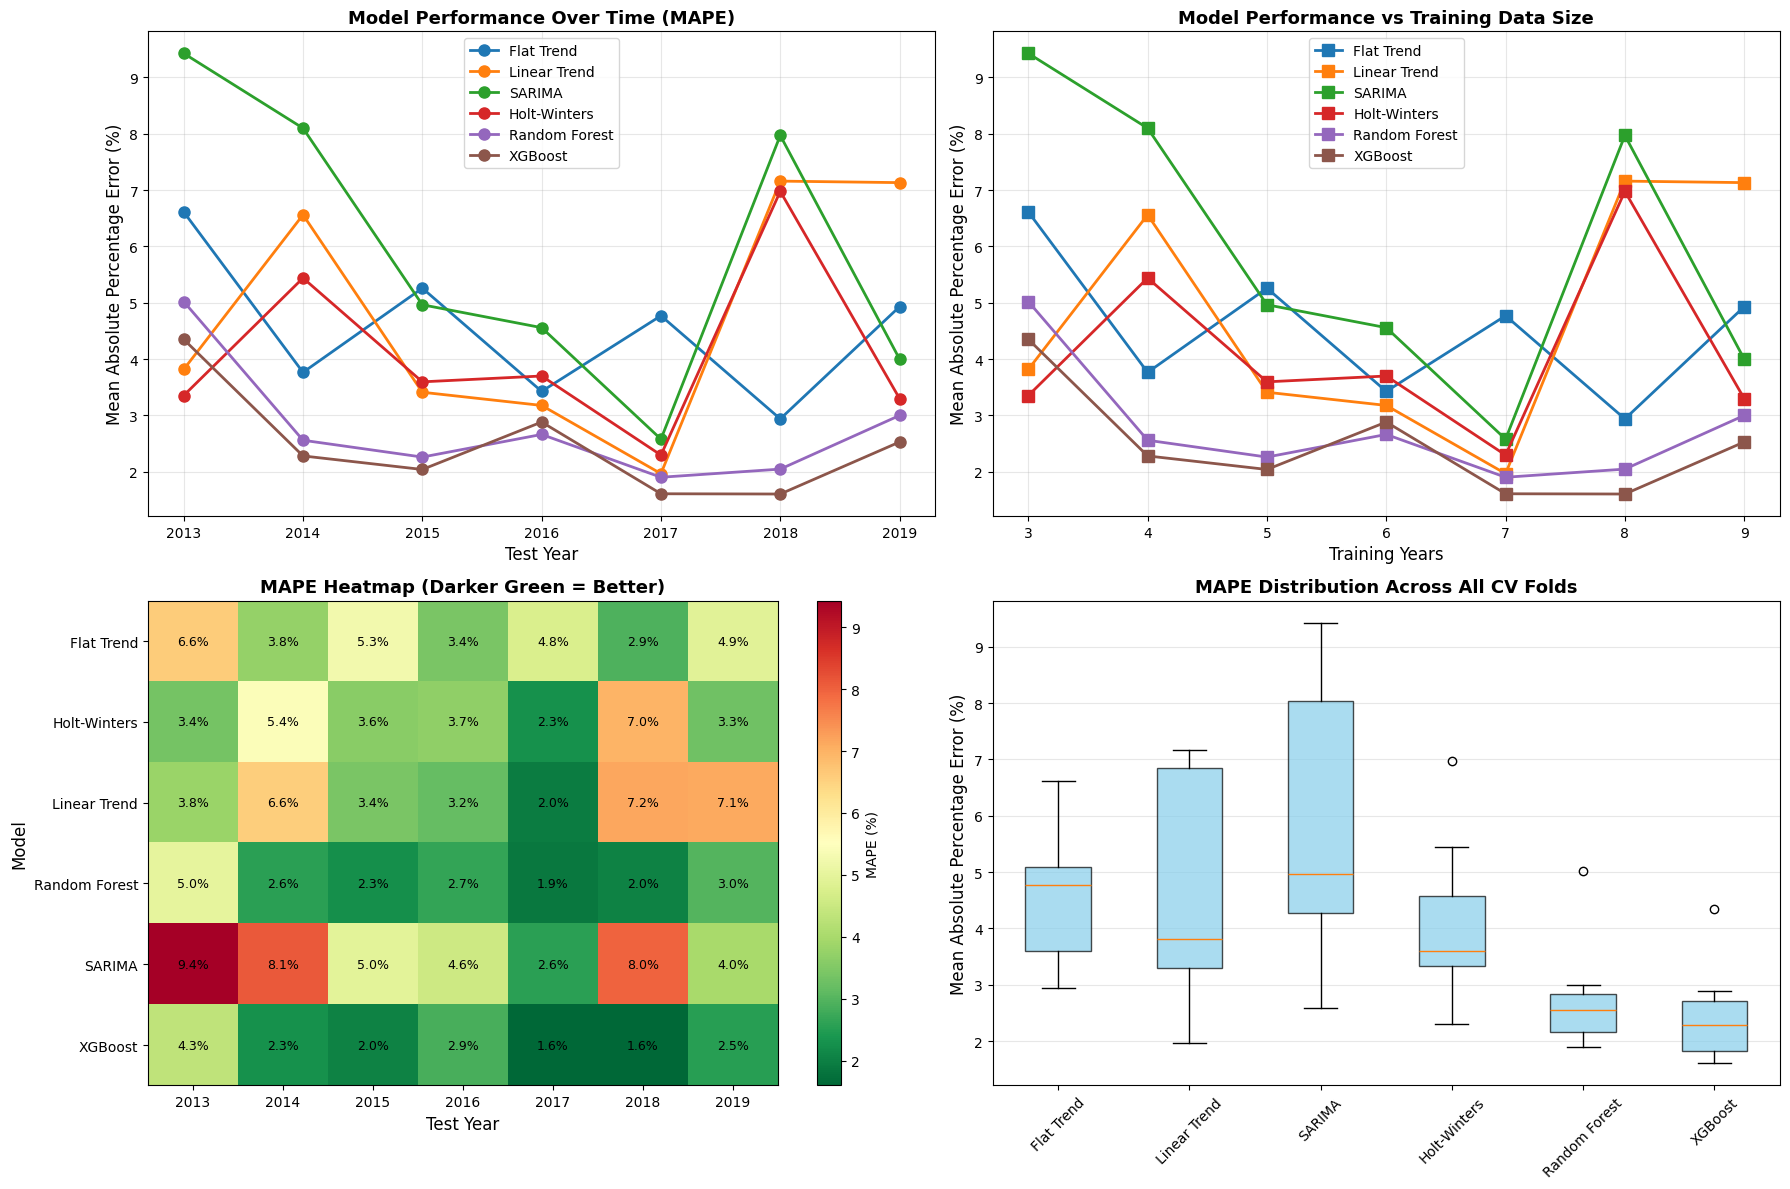

In [20]:
# Visualize cross-validation results (MAPE-focused)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. MAPE over time for each model
for model in models:
    model_data = cv_df[cv_df['Model'] == model].sort_values('Test Year')
    if len(model_data) > 0:
        axes[0, 0].plot(model_data['Test Year'], model_data['MAPE (%)'], 
                       marker='o', label=model, linewidth=2, markersize=8)

axes[0, 0].set_xlabel('Test Year', fontsize=12)
axes[0, 0].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[0, 0].set_title('Model Performance Over Time (MAPE)', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(cv_df['Test Year'].unique())

# 2. MAPE vs Training Years for each model
for model in models:
    model_data = cv_df[cv_df['Model'] == model].sort_values('Training Years')
    if len(model_data) > 0:
        axes[0, 1].plot(model_data['Training Years'], model_data['MAPE (%)'], 
                       marker='s', label=model, linewidth=2, markersize=8)

axes[0, 1].set_xlabel('Training Years', fontsize=12)
axes[0, 1].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[0, 1].set_title('Model Performance vs Training Data Size', fontsize=13, fontweight='bold')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True, alpha=0.3)

# 3. Heatmap of MAPE by model and test year
pivot_mape = cv_df.pivot(index='Model', columns='Test Year', values='MAPE (%)')
im = axes[1, 0].imshow(pivot_mape.values, cmap='RdYlGn_r', aspect='auto')

axes[1, 0].set_xticks(np.arange(len(pivot_mape.columns)))
axes[1, 0].set_yticks(np.arange(len(pivot_mape.index)))
axes[1, 0].set_xticklabels(pivot_mape.columns)
axes[1, 0].set_yticklabels(pivot_mape.index)
axes[1, 0].set_xlabel('Test Year', fontsize=12)
axes[1, 0].set_ylabel('Model', fontsize=12)
axes[1, 0].set_title('MAPE Heatmap (Darker Green = Better)', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(len(pivot_mape.index)):
    for j in range(len(pivot_mape.columns)):
        value = pivot_mape.values[i, j]
        if not np.isnan(value):
            text = axes[1, 0].text(j, i, f'{value:.1f}%',
                                  ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=axes[1, 0], label='MAPE (%)')

# 4. Box plot of MAPE distribution by model
mape_by_model = [cv_df[cv_df['Model'] == model]['MAPE (%)'].values for model in models if len(cv_df[cv_df['Model'] == model]) > 0]
model_labels = [model for model in models if len(cv_df[cv_df['Model'] == model]) > 0]
bp = axes[1, 1].boxplot(mape_by_model, labels=model_labels, patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('skyblue')
    patch.set_alpha(0.7)

axes[1, 1].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[1, 1].set_title('MAPE Distribution Across All CV Folds', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# Detailed CV results table (MAPE-focused)
print("="*90)
print("DETAILED CROSS-VALIDATION RESULTS")
print("="*90)

# Create a pivot table showing MAPE for each model across years
pivot_table = cv_df.pivot_table(
    index='Model', 
    columns='Test Year', 
    values='MAPE (%)', 
    aggfunc='mean'
)

# Add average column
pivot_table['Average'] = pivot_table.mean(axis=1)
pivot_table['Std Dev'] = cv_df.groupby('Model')['MAPE (%)'].std()

# Sort by average performance (lower is better)
pivot_table = pivot_table.sort_values('Average')

print("\nMAPE by Test Year (%):")
print(pivot_table.to_string())

# Calculate improvement relative to baseline (Flat Trend)
print("\n" + "="*90)
print("IMPROVEMENT OVER BASELINE (Flat Trend)")
print("="*90)

baseline_avg = pivot_table.loc['Flat Trend', 'Average']

improvement_df = pd.DataFrame({
    'Model': pivot_table.index,
    'Average MAPE (%)': pivot_table['Average'],
    'Improvement (pp)': baseline_avg - pivot_table['Average'],
    'Improvement (%)': ((baseline_avg - pivot_table['Average']) / baseline_avg * 100).round(2)
})

print(improvement_df.to_string(index=False))

DETAILED CROSS-VALIDATION RESULTS

MAPE by Test Year (%):
Test Year          2013      2014      2015      2016      2017      2018      2019   Average   Std Dev
Model                                                                                                  
XGBoost        4.349907  2.279577  2.038956  2.881292  1.607692  1.603093  2.527059  2.469654  0.950757
Random Forest  5.020680  2.557993  2.259335  2.661057  1.900954  2.045564  2.998221  2.777686  1.057897
Holt-Winters   3.352052  5.438406  3.595034  3.698611  2.294614  6.977120  3.297736  4.093368  1.578365
Flat Trend     6.612135  3.763070  5.257882  3.425655  4.768829  2.936980  4.929755  4.527758  1.253487
Linear Trend   3.815877  6.560863  3.410359  3.176113  1.964950  7.159006  7.132127  4.745614  2.147005
SARIMA         9.427133  8.098770  4.963650  4.556938  2.577390  7.969609  3.998785  5.941754  2.545626

IMPROVEMENT OVER BASELINE (Flat Trend)
        Model  Average MAPE (%)  Improvement (pp)  Improvement (%)
   

In [19]:
# Analyze the effect of training data size (MAPE-focused)
print("="*90)
print("TRAINING DATA SIZE ANALYSIS")
print("="*90)

# For each model, see how performance changes with more training data
for model in models:
    model_data = cv_df[cv_df['Model'] == model].sort_values('Training Years')
    
    if len(model_data) > 1:
        # Calculate correlation between training years and MAPE
        correlation = np.corrcoef(model_data['Training Years'], model_data['MAPE (%)'])[0, 1]
        
        # Calculate improvement from min to max training data
        min_train_mape = model_data.iloc[0]['MAPE (%)']
        max_train_mape = model_data.iloc[-1]['MAPE (%)']
        improvement = ((min_train_mape - max_train_mape) / min_train_mape) * 100
        
        print(f"\n{model}:")
        print(f"  Correlation (training years vs MAPE): {correlation:.3f}")
        print(f"  MAPE with {model_data.iloc[0]['Training Years']} years: {min_train_mape:.2f}%")
        print(f"  MAPE with {model_data.iloc[-1]['Training Years']} years: {max_train_mape:.2f}%")
        print(f"  Improvement: {improvement:.2f}%")
        
        if correlation < -0.3:
            print(f"  → More training data HELPS (negative correlation)")
        elif correlation > 0.3:
            print(f"  → More training data HURTS (positive correlation)")
        else:
            print(f"  → Training data size has MINIMAL IMPACT")

print("\n" + "="*90)

TRAINING DATA SIZE ANALYSIS

Flat Trend:
  Correlation (training years vs MAPE): -0.442
  MAPE with 3 years: 6.61%
  MAPE with 9 years: 4.93%
  Improvement: 25.44%
  → More training data HELPS (negative correlation)

Linear Trend:
  Correlation (training years vs MAPE): 0.349
  MAPE with 3 years: 3.82%
  MAPE with 9 years: 7.13%
  Improvement: -86.91%
  → More training data HURTS (positive correlation)

SARIMA:
  Correlation (training years vs MAPE): -0.574
  MAPE with 3 years: 9.43%
  MAPE with 9 years: 4.00%
  Improvement: 57.58%
  → More training data HELPS (negative correlation)

Holt-Winters:
  Correlation (training years vs MAPE): 0.079
  MAPE with 3 years: 3.35%
  MAPE with 9 years: 3.30%
  Improvement: 1.62%
  → Training data size has MINIMAL IMPACT

Random Forest:
  Correlation (training years vs MAPE): -0.543
  MAPE with 3 years: 5.02%
  MAPE with 9 years: 3.00%
  Improvement: 40.28%
  → More training data HELPS (negative correlation)

XGBoost:
  Correlation (training years v

## Key Insights from Cross-Validation

The time-series cross-validation reveals:

1. **Model Stability**: How consistent each model performs across different time periods
2. **Data Requirements**: Whether models need more historical data to perform well
3. **Temporal Patterns**: If certain years are harder to predict than others
4. **Robustness**: Which models maintain performance with limited training data